# Proyecto Open Data I
## Radares, y su eficiencia en la CAM
### Recopilación, limpieza y tratamiento de los datos
Este cuaderno pretende enseñar el proceso de limpieza de los datos relativos a los radares en la CAM
_Paula Gómez Lucas, Alejandro Majado Martínez_

In [98]:
# Importar librerías
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
from pandas_summary import DataFrameSummary
import textwrap
import geopandas
import utm

from scipy.stats import chisquare

A continuación, se muestra la clase que está compuesta de todos los métodos que se encargan de la limpieza y transformación de los datos

In [2]:
class CSVDataLoader:
    """
    A class for loading and cleaning CSV data from a specified folder path.

    Attributes:
    -----------
    folder_path : str
        The path to the folder containing the CSV files to be loaded.

    data : dict
        A dictionary containing the loaded CSV data, where the keys are the file names and the values are the corresponding dataframes.
    """

    def __init__(self, folder_path):
        """
        Initializes a CSVDataLoader object with the specified folder path.

        Parameters:
        -----------
        folder_path : str
            The path to the folder containing the CSV files to be loaded.
        """
        self.folder_path = folder_path
        self.data = {}
        self.filename = []
        self.keys = []

    def load_data(self):
        """
        Loads CSV data from the specified folder path into a dictionary.

        Returns:
        --------
        None
        """
        csv_files = [f for f in os.listdir(self.folder_path) if f.endswith('.csv')]
        folders = ("datasets/actuacionesBomberos", "datasets/estaciones", "datasets/accidentalidad")
        for folder in folders:
            df = None
            for file in os.listdir(folder):
                filepath = folder + "/" + file
                df1 = pd.read_csv(filepath, sep=';', encoding='utf-8', low_memory=False)
                df = pd.concat([df, df1])
            self.data[str(folder)] = df

        for file_name in csv_files:
            file_path = os.path.join(self.folder_path, file_name)
            try:
                df = pd.read_csv(file_path, sep=';', encoding='latin-1', low_memory=False)
                self.data[str(file_name)] = df
                self.filename.append(file_name)
            except Exception as e:
                print(f"Error al leer {file_name}: {str(e)}")

        for value in self.data.keys():
            self.keys.append(value)

    def clean_data(self):
        """
        Cleans the loaded CSV data by renaming columns, removing whitespace, dropping null values and duplicates, and converting date columns to datetime format.

        Returns:
        --------
        None
        """
        columna_borrar = "Unnamed"
        for df in self.data:
            for j in self.data[df].columns:
                if columna_borrar in j:
                    while j in self.data[df].columns:
                        self.data[df] = self.data[df].drop(j, axis=1)
                        self.data[df] = self.data[df].dropna(how='all', axis=0)
                        
            self.data[df] = self.data[df].rename(columns = lambda x: x.strip().lower().replace(' ', '_'))
            self.data[df] = self.data[df].map(lambda x: x.strip() if isinstance(x, str) else x)
            self.data[df] = self.data[df].dropna(how='all', axis=0)
            self.data[df] = self.data[df].drop_duplicates()
            self.data[df] = self.data[df].loc[:, ~self.data[df].columns.duplicated()]
            self.data[df].columns = map(str.upper, self.data[df].columns)

            if 'FECHA' in self.data[df].columns:
                self.data[df]['FECHA'] = pd.to_datetime(self.data[df]['FECHA'], format='%d/%m/%Y')

#           num_cols = self.data[i].select_dtypes(include='number').columns
#           for col in num_cols:
#               self.data[i][col] = self.data[i][col].fillna(self.data[i][col].mean())

    def get_info(self, filename):
        print(self.data[filename].isnull().sum())
        print(self.data[filename].info())
        
    def get_nan_columns(self):
        j = 0
        for i in self.data:
            print(self.keys[j])
            self.get_info(i)
            j+=1
      
    def get_cleaned_data(self):
        """
        Returns the cleaned CSV data as a dictionary.

        Returns:
        --------
        dict
            A dictionary containing the cleaned CSV data, where the keys are the file names and the values are the corresponding dataframes.
        """
        return self.data

    def create_graph(df, colummn, name):
        frec = df[''+str(colummn)].value_counts()
        aux_df = pd.DataFrame(frec)
        aux_df.columns = ["Frecuencia absoluta"]
        aux_df["Frecuencia relativa"] = 100*aux_df["Frecuencia absoluta"] / len(df)
        frec_rel_cumsum = aux_df["Frecuencia relativa"].cumsum()
        aux_df["Frecuencia relativa acumulada"] = frec_rel_cumsum
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_title('Distribución de '+ str(name))
        ax.bar(aux_df.index, aux_df['Frecuencia absoluta'], color='blue')
        ax2 = ax.twinx()
        ax2.plot(aux_df.index, aux_df['Frecuencia relativa acumulada'], color='red', marker='o', ms = 5)
        ax2.yaxis.set_major_formatter(PercentFormatter())
        ax.tick_params(axis='y', color = 'blue')
        ax2.tick_params(axis='y', color = 'red')
        ax.set_xticklabels(aux_df.index, rotation=90)
        plt.show()

    def dataframe_summary(self, filename):

        numeric_mask = self.data[filename].select_dtypes(include='number').columns

        # Create a DataFrameSummary object
        summary = DataFrameSummary(self.data[filename][numeric_mask])
    
        # Display summary statistics
        summary_stats = summary.summary()
    
        # Plot correlation matrix for all numeric columns
        self.data[filename][numeric_mask].corr(method='pearson', numeric_only=True)

        # Boxplot of each variable
        #self.data[filename][numeric_mask].boxplot(figsize=(10, 8))

        return summary_stats

Una vez está definida la clase con sus métodos, procedemos a declarar las variables que nos permiten trabajar con ello

In [3]:
folder_path = "datasets"
data_loader = CSVDataLoader(folder_path)

La siguiente función carga los datos de los csv a los dataframes

In [4]:
data_loader.load_data()

Limpiamos los datos eliminando las columnas autogeneradas con NaNs, renombramos las columnas para que sean uniformes (minúsculas y con barra bajas), eliminamos las filas de NaNs, eliminamos las filas duplicadas, formateamos todas las variables fecha para que sean consistentes (dd/mm/aaaa), sustituimos los NaNs de las variables numéricas con la media correspondiente a su variable.

In [5]:
data_loader.clean_data()
data = data_loader.get_cleaned_data()

Por último, para confirmar que los datos se han cargado bien, utilizamos el método get_nan_columns para ver cuántos datos en cada columna quedan nulos, así como usamos el método info() de pandas para ver un resumen de todas las columnas y comprobamos también que todo el formateo de las columnas se ha realizado sin problema.

In [6]:
data_loader.get_nan_columns()

datasets/actuacionesBomberos
AÑO                         0
MES                         0
DISTRITO                    0
FUEGOS                      0
DAÑOS_EN_CONSTRUCCION       0
SALVAMENTOS_Y_RESCATES      0
DAÑOS_POR_AGUA              0
INCIDENTES_DIVERSOS         0
SALIDAS_SIN_INTERVENCION    0
SERVICIOS_VARIOS            0
TOTAL                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 0 to 175
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AÑO                       439 non-null    int64 
 1   MES                       439 non-null    object
 2   DISTRITO                  439 non-null    object
 3   FUEGOS                    439 non-null    int64 
 4   DAÑOS_EN_CONSTRUCCION     439 non-null    int64 
 5   SALVAMENTOS_Y_RESCATES    439 non-null    int64 
 6   DAÑOS_POR_AGUA            439 non-null    int64 
 7   INCIDENTES_DIVERSOS       439 non-nul

Efectivamente, se realiza sin problemas. El siguiente paso es el análisis de los datasets columna a columna para revisar qué método usar para rellenar los datos faltantes dependiendo de cada atributo.  

### Sustitución de valores faltantes
Los datasets actuaciones bomberos y estaciones no tienen datos faltantes, por lo que sólo nos queda trabajar con los otros 8 datasets, que podemos observar aquí:

In [7]:
for i in data.keys():
    print(i)

datasets/actuacionesBomberos
datasets/estaciones
datasets/accidentalidad
calendario.csv
DireccionesEvolucionHistorica_20231004.csv
DireccionesVigentes_20231004.csv
iluminacion.csv
padron22.csv
RADARES_FIJOS_vDTT.csv
VialesEvolucionHistorica_20231004.csv
VialesVigentesDistritosBarrios_20231004.csv
VialesVigentesDistritos_20231004.csv
VialesVigentes_20231004.csv


Empecemos con accidentalidad: 

In [8]:
data_loader.get_info('datasets/accidentalidad')
data_loader.data['datasets/accidentalidad']

NUM_EXPEDIENTE               0
FECHA                        0
HORA                         0
LOCALIZACION                 0
NUMERO                       6
COD_DISTRITO                 6
DISTRITO                     6
TIPO_ACCIDENTE               5
ESTADO_METEOROLÓGICO     20120
TIPO_VEHICULO              816
TIPO_PERSONA                 3
RANGO_EDAD                   0
SEXO                         0
COD_LESIVIDAD            85278
LESIVIDAD                85278
COORDENADA_X_UTM             3
COORDENADA_Y_UTM             3
POSITIVA_ALCOHOL           718
POSITIVA_DROGA          195001
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 31157
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NUM_EXPEDIENTE        195610 non-null  object        
 1   FECHA                 195610 non-null  datetime64[ns]
 2   HORA                  195610 non-null  object       

,NUM_EXPEDIENTE,FECHA,HORA,LOCALIZACION,NUMERO,COD_DISTRITO,DISTRITO,TIPO_ACCIDENTE,ESTADO_METEOROLÓGICO,TIPO_VEHICULO,TIPO_PERSONA,RANGO_EDAD,SEXO,COD_LESIVIDAD,LESIVIDAD,COORDENADA_X_UTM,COORDENADA_Y_UTM,POSITIVA_ALCOHOL,POSITIVA_DROGA
0,2018S017842,2019-02-04,9:10:00,"CALL. ALBERTO AGUILERA, 1",1,1.0,CENTRO,Colisión lateral,Despejado,Motocicleta > 125cc,Conductor,De 45 a 49 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,"440068,049","4475679,17",N,NaN
1,2018S017842,2019-02-04,9:10:00,"CALL. ALBERTO AGUILERA, 1",1,1.0,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 30 a 34 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,"440068,049","4475679,17",N,NaN
2,2019S000001,2019-01-01,3:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Furgoneta,Conductor,De 40 a 44 años,Hombre,NaN,NaN,"439139,603","4470836,854",S,NaN
3,2019S000001,2019-01-01,3:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Turismo,Conductor,De 40 a 44 años,Mujer,NaN,NaN,"439139,603","4470836,854",N,NaN
4,2019S000001,2019-01-01,3:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,NaN,Turismo,Conductor,De 45 a 49 años,Mujer,NaN,NaN,"439139,603","4470836,854",N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31153,2023S028337,2023-08-31,23:20:00,"CALL. GOLFO DE SALONICA, 12",12,16.0,HORTALEZA,Otro,Despejado,Turismo,Pasajero,De 55 a 59 años,Mujer,14.0,Sin asistencia sanitaria,443580.365,4480912.376,N,NaN
31154,2023S028341,2023-08-31,22:30:00,CALLE SAN SERAPIO,1,12.0,USERA,Alcance,Despejado,Motocicleta hasta 125cc,Conductor,De 30 a 34 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,440795.55,4471044.789,N,NaN
31155,2023S028341,2023-08-31,22:30:00,CALLE SAN SERAPIO,1,12.0,USERA,Alcance,Despejado,Turismo,Conductor,De 35 a 39 años,Hombre,14.0,Sin asistencia sanitaria,440795.55,4471044.789,N,NaN
31156,2023S028352,2023-08-31,14:40:00,"AUTOV. M-30, 00NC06",00NC06,5.0,CHAMARTÍN,Caída,Despejado,Motocicleta hasta 125cc,Conductor,De 40 a 44 años,Hombre,1.0,Atención en urgencias sin posterior ingreso,442825.5,4481003.193,N,NaN


Hay algunos datos faltantes que tiene sentido que lo sean, y podemos sustituir por un buzzword de algún tipo que nos haga saber que se trate de esto, como lo es que en un accidente en el que no se han producido lesiones, la lesividad sea nula y tampoco haya código de la misma, y como ambas cifras coinciden, es lógico pensar que se trata de las mismas situaciones. Podemos sustituir entonces todos los NaNs de Lesividad faltantes por 'Se desconoce' y el código por 77.

In [9]:
print(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].unique())

[ 7. nan  2. 14.  5.  3.  1.  6.  4. 77.]


In [10]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==1)


0                                                NaN
1                                                NaN
2                                                NaN
3                                                NaN
4                                                NaN
                            ...                     
31153                                            NaN
31154                                            NaN
31155                                            NaN
31156    Atención en urgencias sin posterior ingreso
31157                                            NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [11]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==2)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
31153    NaN
31154    NaN
31155    NaN
31156    NaN
31157    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [12]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==3)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
31153    NaN
31154    NaN
31155    NaN
31156    NaN
31157    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [13]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==4)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
31153    NaN
31154    NaN
31155    NaN
31156    NaN
31157    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [14]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==5)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
31153    NaN
31154    NaN
31155    NaN
31156    NaN
31157    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [15]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==6)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
31153    NaN
31154    NaN
31155    NaN
31156    NaN
31157    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [16]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==7)

0        Asistencia sanitaria sólo en el lugar del acci...
1        Asistencia sanitaria sólo en el lugar del acci...
2                                                      NaN
3                                                      NaN
4                                                      NaN
                               ...                        
31153                                                  NaN
31154    Asistencia sanitaria sólo en el lugar del acci...
31155                                                  NaN
31156                                                  NaN
31157                                                  NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [17]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==14)

0                             NaN
1                             NaN
2                             NaN
3                             NaN
4                             NaN
                   ...           
31153    Sin asistencia sanitaria
31154                         NaN
31155    Sin asistencia sanitaria
31156                         NaN
31157                         NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [18]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==77)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
31153    NaN
31154    NaN
31155    NaN
31156    NaN
31157    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [19]:
# Mapping dictionary
mapping_dict = {
    1: 'Atención en urgencias sin posterior ingreso',
    2: 'Ingreso inferior o igual a 24 horas',
    3: 'Ingreso superior a 24 horas',
    4: 'Fallecido 24 horas',
    5: 'Asistencia sanitaria ambulatoria con posterioridad',
    6: 'Asistencia sanitaria inmediata en centro de salud o mutua',
    7: 'Asistencia sanitaria sólo en el lugar del accidente',
    14: 'Sin asistencia sanitaria',
    77: 'Se desconoce',
}

# Fill missing values using the mapping dictionary
data_loader.data['datasets/accidentalidad']['LESIVIDAD'] = data_loader.data['datasets/accidentalidad']['LESIVIDAD'].fillna(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].map(mapping_dict))
data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'] = data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].fillna(data_loader.data['datasets/accidentalidad']['LESIVIDAD'].map({v: k for k, v in mapping_dict.items()}))

data_loader.data['datasets/accidentalidad']['LESIVIDAD'].fillna('Se desconoce', inplace=True)
data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].fillna(77, inplace=True)


Por otro lado, positivo en droga tiene valor sólo si daba positivo, por lo que rellenar los valores faltantes con 0 es lo más lógico (siendo 0 negativo en droga). 

In [20]:
data_loader.data['datasets/accidentalidad']['POSITIVA_DROGA'] = data_loader.data['datasets/accidentalidad']['POSITIVA_DROGA'].fillna(0)

Número, código de distrito, tipo de accidente, coordenadas (x e y), son atributos a los que sólo les falta un dato cada uno, por lo que no es representativo esta falta de datos y podemos rellenarlos con el valor más habitual. 

In [21]:
numero = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
codDistrito = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
distrito = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
accidente = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
coorX = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]
coorY = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].mode().iat[0]


data_loader.data['datasets/accidentalidad']['NUMERO'] = data_loader.data['datasets/accidentalidad']['NUMERO'].fillna(numero)
data_loader.data['datasets/accidentalidad']['COD_DISTRITO'] = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].fillna(codDistrito)
data_loader.data['datasets/accidentalidad']['DISTRITO'] = data_loader.data['datasets/accidentalidad']['DISTRITO'].fillna(distrito)
data_loader.data['datasets/accidentalidad']['TIPO_ACCIDENTE'] = data_loader.data['datasets/accidentalidad']['TIPO_ACCIDENTE'].fillna(accidente)
data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'] = data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'].fillna(coorX)
data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'] = data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'].fillna(coorY)


Por último, donde queda dilema es en positivo alcohol, tipo de vehículo y estado meteorológico. En esta situación, lo más apropiado es ver si, relacionando estos atributos con algún otro, es más probable que los atributos valgan uno u otro valor.

- Estado meteorológico. Hay 7 valores posibles: despejado, lluvia débil, lluvia intensa, granizando, nevando, nublado, se desconoce. Aquí, por lo tanto, hay 3 vías de actuación:
    - Rellenar con "se desconoce", i.e.: ser fieles a lo que se sabe, reducir la proporción de datos artificiales (hay un 11% de datos faltantes), solución sencilla.
    - Rellenar con el valor más frecuente: despejado (representa el 75% de los datos), i.e.: solución con datos artificiales más sencilla.
    - Rellenar con valores aleatorios según la proporción en la que aparecen los datos, i.e.: el 75% de los datos faltantes se rellenan arbitrariamente con "Despejado".

    Lo que mejor preserva los datos es, rellenar con "se desconoce", pues la variable existe previamente.

In [22]:
data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO'] = data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO'].fillna('Se desconoce')

- Tipo de vehículo. Hay 34 valores posibles: Ambulancia SAMUR, autobús EMT, autobús, autobús articulado, autobús articulado EMT, autocaravana, bicicleta, bicicleta EPAC (pedaleo asistido), camión de bomberos, camión rígido, ciclo, ciclomotor, ciclomotor de dos ruedas L1e-B, cuadriciclo ligero, cuadriciclo no ligero, furgoneta, maquinaria de obras, microbús <= 17 plazas, moto de tres ruedas > 125cc, moto de tres ruedas hasta 125cc, motocicleta > 125cc, motocicleta hasta 125cc, otros vehículos con motor, otros vehículos sin motor, patinete no eléctrico, remolque, semirremolque, sin especificar, todo terreno, tractocamión, tren/metro, turismo (68%), VMU eléctrico, vehículo articulado. En esta variable hay 0.6% de valores faltantes, lo cual no es significativo, i.e.: la sustitución que elijamos tendrá menos repercusión en el estudio final. Aquí, por lo tanto, hay 2 vías de actuación:
    - Rellenar con "sin especificar", i.e.: solución sencilla y descriptiva pero que puede dar lugar a interpretaciones erróneas, pues puede haber sido otro tipo de vehículo que no se había registrado.
    - Rellenar con el valor más probable según otro atributo (por ejemplo, código de lesividad).
    
    La solución más apropiada es rellenar con el valor más probable según código de lesividad, por lo que vamos a ver primero cómo se relacionan ambos atributos y después rellenaremos los valores faltantes con el valor más probable.

In [23]:
data_loader.data['datasets/accidentalidad']['TIPO_VEHICULO'] = data_loader.data['datasets/accidentalidad']['TIPO_VEHICULO'].fillna(data_loader.data['datasets/accidentalidad'].groupby('COD_LESIVIDAD')['TIPO_VEHICULO'].transform(lambda x:x.mode().iat[0]))

Para rellenar los datos de positivo en alcohol, usaremos lo más habitual según grupo de edad, sexo y lesividad de la persona

In [24]:
data_loader.data['datasets/accidentalidad']["POSITIVA_ALCOHOL"] = data_loader.data['datasets/accidentalidad'].groupby(['RANGO_EDAD','SEXO','LESIVIDAD'])['POSITIVA_ALCOHOL'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty                                                                                                        else "Empty"))

Para determinar el tipo de persona, usaremos de criterio el rango de edad y la lesividad -si bien sólo faltan 3 datos, en esta situación podemos realizar un ajuste más específico-

In [25]:
data_loader.data['datasets/accidentalidad']["TIPO_PERSONA"] = data_loader.data['datasets/accidentalidad'].groupby(['RANGO_EDAD','LESIVIDAD'])['TIPO_PERSONA'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty                                                                                                        else "Empty"))

In [26]:
data_loader.get_info('datasets/accidentalidad')

NUM_EXPEDIENTE          0
FECHA                   0
HORA                    0
LOCALIZACION            0
NUMERO                  0
COD_DISTRITO            0
DISTRITO                0
TIPO_ACCIDENTE          0
ESTADO_METEOROLÓGICO    0
TIPO_VEHICULO           0
TIPO_PERSONA            0
RANGO_EDAD              0
SEXO                    0
COD_LESIVIDAD           0
LESIVIDAD               0
COORDENADA_X_UTM        0
COORDENADA_Y_UTM        0
POSITIVA_ALCOHOL        0
POSITIVA_DROGA          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 31157
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NUM_EXPEDIENTE        195610 non-null  object        
 1   FECHA                 195610 non-null  datetime64[ns]
 2   HORA                  195610 non-null  object        
 3   LOCALIZACION          195610 non-null  object        
 4   NUMERO                195610 

Como podemos comprobar, no quedan datos faltantes. Pasamos a Actuaciones Bomberos:

In [27]:
data_loader.get_info('datasets/actuacionesBomberos')

AÑO                         0
MES                         0
DISTRITO                    0
FUEGOS                      0
DAÑOS_EN_CONSTRUCCION       0
SALVAMENTOS_Y_RESCATES      0
DAÑOS_POR_AGUA              0
INCIDENTES_DIVERSOS         0
SALIDAS_SIN_INTERVENCION    0
SERVICIOS_VARIOS            0
TOTAL                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 0 to 175
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AÑO                       439 non-null    int64 
 1   MES                       439 non-null    object
 2   DISTRITO                  439 non-null    object
 3   FUEGOS                    439 non-null    int64 
 4   DAÑOS_EN_CONSTRUCCION     439 non-null    int64 
 5   SALVAMENTOS_Y_RESCATES    439 non-null    int64 
 6   DAÑOS_POR_AGUA            439 non-null    int64 
 7   INCIDENTES_DIVERSOS       439 non-null    int64 
 8   SALIDAS_SIN_

Este dataset no tiene datos faltantes, pasamos al siguiente. Estaciones:

In [28]:
data_loader.get_info('datasets/estaciones')
data_loader.data['datasets/estaciones']

FDIA     0
FEST     0
FSEN     0
HOR1     0
HOR2     0
HOR3     0
HOR4     0
HOR5     0
HOR6     0
HOR7     0
HOR8     0
HOR9     0
HOR10    0
HOR11    0
HOR12    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 86140 entries, 0 to 7079
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FDIA    86140 non-null  object 
 1   FEST    86140 non-null  object 
 2   FSEN    86140 non-null  object 
 3   HOR1    86140 non-null  float64
 4   HOR2    86140 non-null  float64
 5   HOR3    86140 non-null  float64
 6   HOR4    86140 non-null  float64
 7   HOR5    86140 non-null  float64
 8   HOR6    86140 non-null  float64
 9   HOR7    86140 non-null  float64
 10  HOR8    86140 non-null  float64
 11  HOR9    86140 non-null  float64
 12  HOR10   86140 non-null  float64
 13  HOR11   86140 non-null  float64
 14  HOR12   86140 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.5+ MB
None


,FDIA,FEST,FSEN,HOR1,HOR2,HOR3,HOR4,HOR5,HOR6,HOR7,HOR8,HOR9,HOR10,HOR11,HOR12
0,01/04/2023,ES01,1-,819.0,572.0,467.0,397.0,373.0,393.0,352.0,470.0,713.0,611.0,800.0,992.0
1,01/04/2023,ES01,1=,1223.0,1165.0,832.0,884.0,1016.0,1058.0,1104.0,1407.0,1276.0,994.0,986.0,965.0
2,01/04/2023,ES01,2-,683.0,464.0,361.0,298.0,297.0,416.0,326.0,338.0,526.0,765.0,993.0,1083.0
3,01/04/2023,ES01,2=,1206.0,1077.0,748.0,923.0,964.0,1104.0,1159.0,1083.0,971.0,804.0,767.0,709.0
4,01/04/2023,ES02,1-,312.0,309.0,262.0,213.0,187.0,129.0,150.0,170.0,193.0,260.0,315.0,433.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,30/09/2022,ES59,2=,198.0,193.0,169.0,202.0,248.0,249.0,230.0,230.0,168.0,128.0,79.0,74.0
7076,30/09/2022,ES60,1-,48.0,35.0,28.0,34.0,74.0,166.0,605.0,846.0,666.0,508.0,486.0,554.0
7077,30/09/2022,ES60,1=,472.0,543.0,489.0,488.0,618.0,577.0,565.0,532.0,348.0,210.0,161.0,162.0
7078,30/09/2022,ES60,2-,57.0,51.0,26.0,19.0,48.0,117.0,258.0,616.0,492.0,439.0,489.0,541.0


Este dataset tampoco tiene datos faltantes. Apreciamos que FSEN, aparte de indicar el sentido del tráfico, también indica si son las primeras 12h del día (1- y 2-), o las últimas (1=, 2=). Hacemos 12 nuevos atributos para suplir esto en un formato 24h que es más cómodo.

In [29]:
# Convert 'date' column to datetime if it's not already
data_loader.data['datasets/estaciones']['FDIA'] = pd.to_datetime(data_loader.data['datasets/estaciones']['FDIA'], format='mixed', dayfirst=True)

In [30]:
data_loader.get_info('datasets/estaciones')

FDIA     0
FEST     0
FSEN     0
HOR1     0
HOR2     0
HOR3     0
HOR4     0
HOR5     0
HOR6     0
HOR7     0
HOR8     0
HOR9     0
HOR10    0
HOR11    0
HOR12    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 86140 entries, 0 to 7079
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FDIA    86140 non-null  datetime64[ns]
 1   FEST    86140 non-null  object        
 2   FSEN    86140 non-null  object        
 3   HOR1    86140 non-null  float64       
 4   HOR2    86140 non-null  float64       
 5   HOR3    86140 non-null  float64       
 6   HOR4    86140 non-null  float64       
 7   HOR5    86140 non-null  float64       
 8   HOR6    86140 non-null  float64       
 9   HOR7    86140 non-null  float64       
 10  HOR8    86140 non-null  float64       
 11  HOR9    86140 non-null  float64       
 12  HOR10   86140 non-null  float64       
 13  HOR11   86140 non-null  float64       
 14  HOR12   86

In [31]:
df = data_loader.data['datasets/estaciones']
# Split the FSEN values into direction and hour parts
df[['FSEN_DIRECTION', 'FSEN_AMPM']] = df['FSEN'].str.extract(r'(\d)([=-])')

# Drop unnecessary columns
df.drop(['FSEN'], axis=1, inplace=True)

index = ['FDIA', 'FEST', 'FSEN_DIRECTION', 'FSEN_AMPM', 'HOR1', 'HOR2', 'HOR3', 'HOR4', 'HOR5', 'HOR6', 'HOR7', 'HOR8', 'HOR9', 'HOR10', 'HOR11', 'HOR12', 'HOR13', 'HOR14', 'HOR15', 'HOR16', 'HOR17', 'HOR18', 'HOR19', 'HOR20', 'HOR21', 'HOR22', 'HOR23', 'HOR24']

df.reindex(columns=index)

,FDIA,FEST,FSEN_DIRECTION,FSEN_AMPM,HOR1,HOR2,HOR3,HOR4,HOR5,HOR6,...,HOR15,HOR16,HOR17,HOR18,HOR19,HOR20,HOR21,HOR22,HOR23,HOR24
0,2023-04-01,ES01,1,-,819.0,572.0,467.0,397.0,373.0,393.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-01,ES01,1,=,1223.0,1165.0,832.0,884.0,1016.0,1058.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-01,ES01,2,-,683.0,464.0,361.0,298.0,297.0,416.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-01,ES01,2,=,1206.0,1077.0,748.0,923.0,964.0,1104.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-04-01,ES02,1,-,312.0,309.0,262.0,213.0,187.0,129.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,2022-09-30,ES59,2,=,198.0,193.0,169.0,202.0,248.0,249.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7076,2022-09-30,ES60,1,-,48.0,35.0,28.0,34.0,74.0,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7077,2022-09-30,ES60,1,=,472.0,543.0,489.0,488.0,618.0,577.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7078,2022-09-30,ES60,2,-,57.0,51.0,26.0,19.0,48.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
def group_fn(dff: pd.DataFrame):
    # dff contiene 2 rows de am y pm
    am = dff.loc[dff['FSEN_AMPM'] == "-"].iloc[0]
    pm = dff.loc[dff['FSEN_AMPM'] == "="].iloc[0]
    par = am[['HOR1', 'HOR2', 'HOR3', 'HOR4', 'HOR5', 'HOR6', 'HOR7', 'HOR8', 'HOR9', 'HOR10', 'HOR11', 'HOR12']].copy()
    
    par['HOR13'] = pm['HOR1']
    par['HOR14'] = pm['HOR2']
    par['HOR15'] = pm['HOR3']
    par['HOR16'] = pm['HOR4']
    par['HOR17'] = pm['HOR5']
    par['HOR18'] = pm['HOR6']
    par['HOR19'] = pm['HOR7']
    par['HOR20'] = pm['HOR8']
    par['HOR21'] = pm['HOR9']
    par['HOR22'] = pm['HOR10']
    par['HOR23'] = pm['HOR11']
    par['HOR24'] = pm['HOR12']

    return par

In [33]:
data_loader.data['datasets/estaciones'] = df.groupby(['FEST', 'FDIA', 'FSEN_DIRECTION']).apply(group_fn)
data_loader.data['datasets/estaciones']

HOR1   HOR2   HOR3  HOR4   HOR5   HOR6  \
FEST FDIA       FSEN_DIRECTION                                            
ES01 2022-08-01 1               183.0  128.0  104.0  78.0  164.0  593.0   
                2               205.0  155.0  108.0  78.0  116.0  236.0   
     2022-08-02 1               221.0  111.0   85.0  77.0  166.0  506.0   
                2               117.0  107.0   75.0  59.0  133.0  259.0   
     2022-08-03 1               241.0  125.0   88.0  84.0  144.0  511.0   
...                               ...    ...    ...   ...    ...    ...   
ES60 2023-07-29 2                86.0   65.0   56.0  41.0   40.0   57.0   
     2023-07-30 1                86.0   82.0   56.0  41.0   52.0   77.0   
                2               128.0   88.0   57.0  44.0   49.0   55.0   
     2023-07-31 1                45.0   26.0   25.0  22.0   42.0  138.0   
                2                67.0   45.0   26.0  35.0   22.0   85.0   

                                  HOR7    HOR8    HOR9   HOR10  ...   HOR15  \
FEST FDIA       FSEN_DIRECTION                                  ...           
ES01 2022-08-01 1               1379.0  1483.0  1384.0  1226.0  ...  1232.0   
                2                528.0   948.0   918.0   915.0  ...  1028.0   
     2022-08-02 1               1414.0  1513.0  1335.0  1263.0  ...  1178.0   
                2                561.0   929.0   949.0   871.0  ...  1115.0   
     2022-08-03 1               1373.0  1431.0  1322.0  1175.0  ...  1164.0   
...                                ...     ...     ...     ...  ...     ...   
ES60 2023-07-29 2                 78.0   109.0   206.0   313.0  ...   226.0   
     2023-07-30 1                 74.0   113.0   203.0   301.0  ...   157.0   
                2                 60.0    72.0   126.0   182.0  ...   235.0   
     2023-07-31 1                331.0   413.0   409.0   402.0  ...   277.0   
                2                192.0   253.0   342.0   357.0  ...   423.0   

                                 HOR16   HOR17   HOR18   HOR19  HOR20  HOR21  \
FEST FDIA       FSEN_DIRECTION                                                 
ES01 2022-08-01 1                945.0   993.0  1109.0   924.0  944.0  677.0   
                2                891.0   940.0   957.0   849.0  790.0  572.0   
     2022-08-02 1               1012.0   957.0  1025.0  1024.0  890.0  684.0   
                2                878.0   944.0  1016.0   873.0  876.0  721.0   
     2022-08-03 1                960.0  1015.0  1049.0   986.0  974.0  698.0   
...                                ...     ...     ...     ...    ...    ...   
ES60 2023-07-29 2                224.0   173.0   239.0   270.0  296.0  298.0   
     2023-07-30 1                154.0   196.0   253.0   283.0  267.0  191.0   
                2                221.0   234.0   258.0   312.0  396.0  391.0   
     2023-07-31 1                272.0   347.0   374.0   394.0  323.0  240.0   
                2                340.0   355.0   424.0   415.0  427.0  323.0   

                                HOR22  HOR23  HOR24  
FEST FDIA       FSEN_DIRECTION                       
ES01 2022-08-01 1               556.0  552.0  386.0  
                2               487.0  348.0  275.0  
     2022-08-02 1               486.0  568.0  430.0  
                2               504.0  413.0  312.0  
     2022-08-03 1               540.0  602.0  537.0  
...                               ...    ...    ...  
ES60 2023-07-29 2               231.0  174.0  190.0  
     2023-07-30 1               181.0  109.0   70.0  
                2               273.0  190.0  111.0  
     2023-07-31 1               130.0  102.0   64.0  
                2               228.0  159.0   93.0  

[43070 rows x 24 columns]

In [34]:
data_loader.get_info('datasets/estaciones')

HOR1     0
HOR2     0
HOR3     0
HOR4     0
HOR5     0
HOR6     0
HOR7     0
HOR8     0
HOR9     0
HOR10    0
HOR11    0
HOR12    0
HOR13    0
HOR14    0
HOR15    0
HOR16    0
HOR17    0
HOR18    0
HOR19    0
HOR20    0
HOR21    0
HOR22    0
HOR23    0
HOR24    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43070 entries, ('ES01', Timestamp('2022-08-01 00:00:00'), '1') to ('ES60', Timestamp('2023-07-31 00:00:00'), '2')
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HOR1    43070 non-null  float64
 1   HOR2    43070 non-null  float64
 2   HOR3    43070 non-null  float64
 3   HOR4    43070 non-null  float64
 4   HOR5    43070 non-null  float64
 5   HOR6    43070 non-null  float64
 6   HOR7    43070 non-null  float64
 7   HOR8    43070 non-null  float64
 8   HOR9    43070 non-null  float64
 9   HOR10   43070 non-null  float64
 10  HOR11   43070 non-null  float64
 11  HOR12   43070 non-null  float64
 12  HOR

In [35]:
data_loader.dataframe_summary('datasets/estaciones')

,HOR1,HOR2,HOR3,HOR4,HOR5,HOR6,HOR7,HOR8,HOR9,HOR10,...,HOR15,HOR16,HOR17,HOR18,HOR19,HOR20,HOR21,HOR22,HOR23,HOR24
count,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,...,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0
mean,349.353866,249.446738,178.583074,143.306919,143.192686,228.891688,470.235663,770.226863,898.403065,897.940446,...,1006.635106,980.84632,959.616647,991.763594,1009.949269,987.990504,882.815997,734.660088,589.956675,462.854516
std,586.664755,435.311425,304.584859,223.363963,181.366051,253.470562,572.285139,1065.301401,1223.765007,1218.726208,...,1356.291987,1391.08328,1288.042121,1251.292668,1302.56987,1322.411338,1267.157291,1184.800883,973.216178,742.784157
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,74.0,46.0,34.0,30.0,38.0,56.0,98.0,171.0,232.0,274.0,...,333.0,303.0,308.0,334.0,344.0,335.0,290.0,223.0,162.0,118.0
50%,170.0,115.0,84.0,73.0,85.0,142.0,244.0,432.0,545.0,570.0,...,628.0,603.0,623.0,662.0,661.0,624.0,522.0,409.0,318.0,245.0
75%,378.0,264.0,195.0,158.0,179.0,323.0,625.0,1017.0,1089.0,1046.0,...,1224.0,1143.0,1138.0,1216.0,1245.0,1205.0,1032.0,815.0,672.0,533.0
max,9999.0,7854.0,9999.0,5805.0,3610.0,6234.0,5985.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9991.0,7557.0
counts,43070,43070,43070,43070,43070,43070,43070,43070,43070,43070,...,43070,43070,43070,43070,43070,43070,43070,43070,43070,43070
uniques,2444,2060,1594,1331,1192,1386,2647,3614,3986,3948,...,3942,3833,3630,3863,3924,3843,3789,3458,3096,2682


In [36]:
data_loader.get_info('DireccionesEvolucionHistorica_20231004.csv')

COD_VIA                    0
VIA_SQC               371584
VIA_CLASE                  0
VIA_PAR                17997
VIA_NOMBRE                 0
VIA_NOMBRE_ACENTOS         0
COD_NDP                    0
CLASE_NDP                  0
NÚMERO                     0
CALIFICADOR           322826
FECHA_DE_ALTA              0
FECHA_DE_BAJA         211657
TIPO_NDP               16248
UTMX_ED                    0
UTMY_ED                    0
UTMX_ETRS                  0
UTMY_ETRS                  0
LATITUD                    0
LONGITUD                   0
ANGULO_ROTULACION          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371584 entries, 0 to 371583
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             371584 non-null  int64  
 1   VIA_SQC             0 non-null       float64
 2   VIA_CLASE           371584 non-null  object 
 3   VIA_PAR             353587 non-null  obje

Como podemos observar, faltan datos de las columnas VIA_SQC (secuencia de la denominación), con 371584 NaNs; VIA_PAR (partícula de la denominación), con 17997; CALIFICADOR (del número de la policía), con 322826; FECHA_DE_BAJA (de la dirección), con 211657; y TIPO_NDP (tipo de número: portal, garaje, fachada, etc.) con 16248.

In [37]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']

,COD_VIA,VIA_SQC,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,COD_NDP,CLASE_NDP,NÚMERO,CALIFICADOR,FECHA_DE_ALTA,FECHA_DE_BAJA,TIPO_NDP,UTMX_ED,UTMY_ED,UTMX_ETRS,UTMY_ETRS,LATITUD,LONGITUD,ANGULO_ROTULACION
0,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049663,NUMERO,2,B,13/10/1992,NaN,PORTAL,"443214,74","4485347,45","443105,38","4485139,98",40°30'54.12'' N,3°40'17.75'' W,"85,86"
1,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049663,NUMERO,2,NaN,01/01/1991,13/10/1992,PORTAL,"443214,74","4485347,45","443105,38","4485139,98",40°30'54.12'' N,3°40'17.75'' W,"85,86"
2,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049664,NUMERO,4,NaN,01/01/1991,NaN,PORTAL,"443212,21","4485305,01","443102,86","4485097,54",40°30'52.74'' N,3°40'17.85'' W,"86,29"
3,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,20057084,NUMERO,14,NaN,13/10/1992,NaN,PARCELA,"442858,75","4484933,55","442749,39","4484726,08",40°30'40.61'' N,3°40'32.75'' W,"27,04"
4,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,20057087,NUMERO,16,A,06/11/1998,NaN,PORTAL,"442750,17","4484945,03","442640,81","4484737,56",40°30'40.95'' N,3°40'37.36'' W,"16,81"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371579,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071343,NUMERO,197,B,12/07/2023,NaN,PORTAL,-1,-1,"447989,3","4463631,36",40°19'17.72'' N,3°36'43.89'' W,"63,07"
371580,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071344,NUMERO,207,NaN,12/07/2023,NaN,PORTAL,"447926,45","4463659,51","447816,87","4463451,88",40°19'11.86'' N,3°36'51.14'' W,"52,82"
371581,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071345,NUMERO,211,NaN,12/07/2023,NaN,PORTAL,"447806,87","4463509,48","447697,29","4463301,85",40°19'6.97'' N,3°36'56.17'' W,"69,89"
371582,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071346,NUMERO,213,NaN,12/07/2023,NaN,PORTAL,"447757,71","4463417,13","447648,14","4463209,5",40°19'3.97'' N,3°36'58.22'' W,"53,82"


La secuencia de denominación (VIA_SQC) es solo NaNs, por lo que lo más lógico es eliminar la columna directamente

In [38]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv'].drop('VIA_SQC', axis=1)

Ahora, pasamos a la partícula de denominación (VIA_PAR), hay 7 valores distintos de entre la lista posible de 20 (DE, EL, A, DEL, LA, AL, DE LA, LAS, A LA, DE LAS, LO, A LAS, DE LO, LOS, A LO, DE LO, DE LOS, POR EL, A LOS, POR LA), de los cuales el primero es A LA y el último es DEL. Por lo tanto, parece que no se ha rellenado con Null o espacio vacío aquellas direcciones en las que no hay partícula:

In [39]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['VIA_PAR'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['VIA_PAR'].fillna(' ')

Fecha de baja, si no hay valor, es que está aún de alta, así que también sustituimos por un valor que represente que sigue dado de alta:

In [40]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'].fillna('--/--/----')

Para Tipo de número de policía, rellenaremos con el dato más habitual: PORTAL

In [41]:
tipoNDP = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'].mode().iat[0]
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'].fillna(tipoNDP)

Para Calificador, como no sabemos realmente cuál es el criterio y la mayoría de datos son faltantes (322826 faltan de 371584), lo más prudente es eliminar la columna directamente

In [42]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv'].drop('CALIFICADOR', axis=1)

In [43]:
data_loader.get_info('DireccionesEvolucionHistorica_20231004.csv')

COD_VIA               0
VIA_CLASE             0
VIA_PAR               0
VIA_NOMBRE            0
VIA_NOMBRE_ACENTOS    0
COD_NDP               0
CLASE_NDP             0
NÚMERO                0
FECHA_DE_ALTA         0
FECHA_DE_BAJA         0
TIPO_NDP              0
UTMX_ED               0
UTMY_ED               0
UTMX_ETRS             0
UTMY_ETRS             0
LATITUD               0
LONGITUD              0
ANGULO_ROTULACION     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371584 entries, 0 to 371583
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   COD_VIA             371584 non-null  int64 
 1   VIA_CLASE           371584 non-null  object
 2   VIA_PAR             371584 non-null  object
 3   VIA_NOMBRE          371584 non-null  object
 4   VIA_NOMBRE_ACENTOS  371584 non-null  object
 5   COD_NDP             371584 non-null  int64 
 6   CLASE_NDP           371584 non-null  object
 7 

Efectivamente no quedan Missing Values. Pasamos a las direcciones vigentes:

In [44]:
data_loader.get_info('DireccionesVigentes_20231004.csv')

COD_VIA                    0
VIA_CLASE                  0
VIA_PAR                 3381
VIA_NOMBRE                 0
VIA_NOMBRE_ACENTOS         0
CLASE_APP                  0
NUMERO                     0
CALIFICADOR           178838
TIPO_NDP                   0
COD_NDP                    0
DISTRITO                   0
BARRIO                     0
COD_POSTAL                 0
UTMX_ED                    0
UTMY_ED                    0
UTMX_ETRS                  0
UTMY_ETRS                  0
LATITUD                    0
LONGITUD                   0
ANGULO_ROTULACION          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 210384 entries, 0 to 210663
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             210384 non-null  int64  
 1   VIA_CLASE           210384 non-null  object 
 2   VIA_PAR             207003 non-null  object 
 3   VIA_NOMBRE          210384 non-null  object 
 

Faltan valores en Vía Par (3381) y en Calificador (178838), los sustituimos con el mismo criterio que en el dataset anterior:

In [45]:
data_loader.data['DireccionesVigentes_20231004.csv']['VIA_PAR'] = data_loader.data['DireccionesVigentes_20231004.csv']['VIA_PAR'].fillna(' ')

In [46]:
data_loader.data['DireccionesVigentes_20231004.csv'] = data_loader.data['DireccionesVigentes_20231004.csv'].drop('CALIFICADOR', axis=1)

In [47]:
data_loader.get_info('DireccionesVigentes_20231004.csv')

COD_VIA               0
VIA_CLASE             0
VIA_PAR               0
VIA_NOMBRE            0
VIA_NOMBRE_ACENTOS    0
CLASE_APP             0
NUMERO                0
TIPO_NDP              0
COD_NDP               0
DISTRITO              0
BARRIO                0
COD_POSTAL            0
UTMX_ED               0
UTMY_ED               0
UTMX_ETRS             0
UTMY_ETRS             0
LATITUD               0
LONGITUD              0
ANGULO_ROTULACION     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 210384 entries, 0 to 210663
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             210384 non-null  int64  
 1   VIA_CLASE           210384 non-null  object 
 2   VIA_PAR             210384 non-null  object 
 3   VIA_NOMBRE          210384 non-null  object 
 4   VIA_NOMBRE_ACENTOS  210384 non-null  object 
 5   CLASE_APP           210384 non-null  object 
 6   NUMERO              

Pasamos al dataset estrella: radares.

In [48]:
data_loader.get_info('RADARES_FIJOS_vDTT.csv')
data_loader.data['RADARES_FIJOS_vDTT.csv']

Nº\nRADAR               0
UBICACION               0
CARRETARA_O_VIAL        1
UBICACIÓN\nCALLE_30     8
PK                      1
SENTIDO                 3
TIPO                    3
X_(WGS84)              13
Y_(WGS84)              13
LONGITUD                0
LATITUD                 0
COORDENADAS             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nº
RADAR            29 non-null     int64 
 1   UBICACION           29 non-null     object
 2   CARRETARA_O_VIAL    28 non-null     object
 3   UBICACIÓN
CALLE_30  21 non-null     object
 4   PK                  28 non-null     object
 5   SENTIDO             26 non-null     object
 6   TIPO                26 non-null     object
 7   X_(WGS84)           16 non-null     object
 8   Y_(WGS84)           16 non-null     object
 9   LONGITUD            29 non-null     obj

,Nº\nRADAR,UBICACION,CARRETARA_O_VIAL,UBICACIÓN\nCALLE_30,PK,SENTIDO,TIPO,X_(WGS84),Y_(WGS84),LONGITUD,LATITUD,COORDENADAS
0,1,"M-30, ENTRADA DE LA A-1, SENTIDO PUENTE DE VEN...",M-30,00NC50,0+500,Calzada interior,Fijo carriles 3 y 4,442843.00,4481180.00,-367.433.808,4.047.934.148,DGP
1,2,"M-30, ENTRADA DE LA A-1, SENTIDO PUENTE DE VEN...",M-30,00NC50,0+500,Calzada interior,Fijo carriles 3 y 4,442847.00,4481180.00,-367.429.089,4.047.934.175,DGP
2,3,"PASO INFERIOR COSTA RICA, SENTIDO PRÍNCIPE DE ...",NaN,NaN,NaN,NaN,NaN,443295.00,4478910.00,-366.880.283,4.045.892.328,DGP
3,4,"M-30, PTE. DE VENTAS. SENTIDO SUR A O´DONNELL ...",M-30,M-30,6+700,Tronco calzada interior,"Fijo carriles 1, 2 y 3",444002.00,4475270.00,-366.014.384,4.042.618.023,DGP
4,5,"M-30, PTE. DE VENTAS. SENTIDO SUR A O´DONNELL ...",M-30,M-30,6+700,Tronco calzada interior,"Fijo carriles 1, 2 y 3",444009.00,4475271.00,-366.006.141,4.042.618.971,DGP
5,6,"M-30, ENLACE O´DONNELL SENTIDO NORTE A PTE. DE...",M-30,M-30,7+800,Tronco calzada exterior,Fijo carriles 2 y 3,444069.00,4474210.00,-365.926.082,4.041.663.568,DGP
6,7,"M-30, ENLACE O´DONNELL SENTIDO NORTE A PTE. DE...",M-30,M-30,7+800,Tronco calzada exterior,Fijo carriles 2 y 3,444066.00,4474211.00,-365.929.627,4.041.664.449,DGP
7,8,"TÚNEL BAIPÁS, SENTIDO NORTE A PTE. DE VENTAS (...",M-30,10XC30,10+300,Calzada exterior,Fijo carril 1,NaN,NaN,-3.670.048,40.397.352,Calle30
8,9,"TÚNEL BAIPÁS, SENTIDO NORTE A PTE. DE VENTAS (...",M-30,10XC30,10+300,Calzada exterior,Fijo carril 3,NaN,NaN,-3.669.973,40.397.323,Calle30
9,10,"ENTRADA TÚNEL M-30, DESDE NUDO SUR HACIA PTE. ...",M-30,13NL25,13+250,Calzada interior,Fijo carril 3,NaN,NaN,-369.499.826,4.038.678.654,Calle30


Carretera o vial, PK, sentido y tipo tienen muy poca frecuencia de NaNs, por lo que solo sustituimos por los valores más frecuentes

In [49]:
carretera = data_loader.data['RADARES_FIJOS_vDTT.csv']['CARRETARA_O_VIAL'].mode().iat[0]
pk = data_loader.data['RADARES_FIJOS_vDTT.csv']['PK'].mode().iat[0]
sentido = data_loader.data['RADARES_FIJOS_vDTT.csv']['SENTIDO'].mode().iat[0]
tipo = data_loader.data['RADARES_FIJOS_vDTT.csv']['TIPO'].mode().iat[0]

data_loader.data['RADARES_FIJOS_vDTT.csv']['CARRETARA_O_VIAL'] = data_loader.data['RADARES_FIJOS_vDTT.csv']['CARRETARA_O_VIAL'].fillna(carretera)
data_loader.data['RADARES_FIJOS_vDTT.csv']['PK'] = data_loader.data['RADARES_FIJOS_vDTT.csv']['PK'].fillna(pk)
data_loader.data['RADARES_FIJOS_vDTT.csv']['SENTIDO'] = data_loader.data['RADARES_FIJOS_vDTT.csv']['SENTIDO'].fillna(sentido)
data_loader.data['RADARES_FIJOS_vDTT.csv']['TIPO'] = data_loader.data['RADARES_FIJOS_vDTT.csv']['TIPO'].fillna(tipo)

In [99]:
data_loader.data['RADARES_FIJOS_vDTT.csv'] = data_loader.data['RADARES_FIJOS_vDTT.csv'].drop('X_(WGS84)', axis=1)
data_loader.data['RADARES_FIJOS_vDTT.csv'] = data_loader.data['RADARES_FIJOS_vDTT.csv'].drop('Y_(WGS84)', axis=1)

data_loader.get_info('RADARES_FIJOS_vDTT.csv')

Nº\nRADAR              0
UBICACION              0
CARRETARA_O_VIAL       0
UBICACIÓN\nCALLE_30    8
PK                     0
SENTIDO                0
TIPO                   0
LONGITUD               0
LATITUD                0
COORDENADAS            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nº
RADAR            29 non-null     int64 
 1   UBICACION           29 non-null     object
 2   CARRETARA_O_VIAL    29 non-null     object
 3   UBICACIÓN
CALLE_30  21 non-null     object
 4   PK                  29 non-null     object
 5   SENTIDO             29 non-null     object
 6   TIPO                29 non-null     object
 7   LONGITUD            29 non-null     object
 8   LATITUD             29 non-null     object
 9   COORDENADAS         29 non-null     object
dtypes: int64(1), object(9)
memory usage: 2.4+ KB
None


In [51]:
data_loader.data['RADARES_FIJOS_vDTT.csv'].

A continuación identificamos los faltantes en la evolución histórica de viales:


In [52]:
data_loader.get_info('VialesEvolucionHistorica_20231004.csv')
data_loader.data['VialesEvolucionHistorica_20231004.csv']

COD_VIA                  0
VIA_SQC                  0
VIA_CLASE                0
VIA_PAR               1724
VIA_NOMBRE               0
VIA_NOMBRE_ACENTOS       0
FECHA_DE_ALTA            0
FECHA_DE_BAJA         9354
VIA_ESTADO               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   COD_VIA             16446 non-null  int64 
 1   VIA_SQC             16446 non-null  int64 
 2   VIA_CLASE           16446 non-null  object
 3   VIA_PAR             14722 non-null  object
 4   VIA_NOMBRE          16446 non-null  object
 5   VIA_NOMBRE_ACENTOS  16446 non-null  object
 6   FECHA_DE_ALTA       16446 non-null  object
 7   FECHA_DE_BAJA       7092 non-null   object
 8   VIA_ESTADO          16446 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB
None


,COD_VIA,VIA_SQC,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,FECHA_DE_ALTA,FECHA_DE_BAJA,VIA_ESTADO
0,125,1,CALLE,NaN,A,A,01/01/1977,27/12/1985,H
1,127,1,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,31/10/1985,NaN,V
2,127,2,CALLE,NaN,A,A,01/08/1983,31/10/1985,V
3,130,2,CALLE,DE,ELIAS TORMO,ELÍAS TORMO,27/12/1985,01/01/2004,H
4,130,1,CALLE,NaN,A,A,01/01/1973,27/12/1985,H
...,...,...,...,...,...,...,...,...,...
16441,31006177,2,CALLE,DEL,BARRON,BARRÓN,18/02/1953,30/04/1953,H
16442,31006177,1,CALLE,DEL,TESORO,TESORO,01/01/1902,18/02/1953,H
16443,31006181,1,PLAZA,DE,JUAN MUÑOZ MARTIN,JUAN MUÑOZ MARTÍN,25/05/2023,NaN,V
16444,31006183,1,CALLE,NaN,PROVISIONAL AHIJONES TREINTA A,PROVISIONAL AHIJONES TREINTA A,03/03/2023,NaN,V


Faltan VIA_PAR y FECHA_DE_BAJA, que ya se han tratado en dataframes previos y manejaremos de la misma manera:

In [53]:
data_loader.data['VialesEvolucionHistorica_20231004.csv']['VIA_PAR'] = data_loader.data['VialesEvolucionHistorica_20231004.csv']['VIA_PAR'].fillna(' ')
data_loader.data['VialesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'] = data_loader.data['VialesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'].fillna('--/--/----')

In [54]:
data_loader.get_info('VialesEvolucionHistorica_20231004.csv')

COD_VIA               0
VIA_SQC               0
VIA_CLASE             0
VIA_PAR               0
VIA_NOMBRE            0
VIA_NOMBRE_ACENTOS    0
FECHA_DE_ALTA         0
FECHA_DE_BAJA         0
VIA_ESTADO            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   COD_VIA             16446 non-null  int64 
 1   VIA_SQC             16446 non-null  int64 
 2   VIA_CLASE           16446 non-null  object
 3   VIA_PAR             16446 non-null  object
 4   VIA_NOMBRE          16446 non-null  object
 5   VIA_NOMBRE_ACENTOS  16446 non-null  object
 6   FECHA_DE_ALTA       16446 non-null  object
 7   FECHA_DE_BAJA       16446 non-null  object
 8   VIA_ESTADO          16446 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB
None


Pasamos al dataframe de viales vigentes distritos barrios:

In [55]:
data_loader.get_info('VialesVigentesDistritosBarrios_20231004.csv')
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']

COD_VIA                  0
VIA_CLASE                0
VIA_PAR                601
VIA_NOMBRE               0
VIA_NOMBRE_ACENTOS       0
DISTRITO                24
BARRIO                  24
IMPAR_MIN             2719
IMPAR_MAX             2719
PAR_MIN               2558
PAR_MAX               2558
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 11014 entries, 0 to 11025
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   COD_VIA             11014 non-null  int64  
 1   VIA_CLASE           11014 non-null  object 
 2   VIA_PAR             10413 non-null  object 
 3   VIA_NOMBRE          11014 non-null  object 
 4   VIA_NOMBRE_ACENTOS  11014 non-null  object 
 5   DISTRITO            10990 non-null  float64
 6   BARRIO              10990 non-null  float64
 7   IMPAR_MIN           8295 non-null   float64
 8   IMPAR_MAX           8295 non-null   float64
 9   PAR_MIN             8456 non-null   float6

,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,DISTRITO,BARRIO,IMPAR_MIN,IMPAR_MAX,PAR_MIN,PAR_MAX
0,31001337,AUTOVÍA,NaN,A-1,A-1,16.0,6.0,NaN,NaN,10000.0,13000.0
1,31001336,AUTOVÍA,NaN,A-2,A-2,4.0,4.0,NaN,NaN,NaN,NaN
2,31001336,AUTOVÍA,NaN,A-2,A-2,5.0,2.0,NaN,NaN,NaN,NaN
3,31001336,AUTOVÍA,NaN,A-2,A-2,15.0,5.0,NaN,NaN,5000.0,5000.0
4,31001336,AUTOVÍA,NaN,A-2,A-2,15.0,6.0,NaN,NaN,5000.0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...
11021,807100,CALLE,DE,ZURBARAN,ZURBARÁN,7.0,4.0,1.0,23.0,2.0,32.0
11022,807200,CALLE,DE,ZURGENA,ZURGENA,20.0,1.0,NaN,NaN,NaN,NaN
11023,2462,CALLE,DE,ZURICH,ZURICH,20.0,5.0,1.0,41.0,2.0,16.0
11024,807300,CALLE,DE,ZURITA,ZURITA,1.0,2.0,1.0,47.0,2.0,44.0


VIA_PAR hacemos la misma solución que previamente:

In [56]:
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['VIA_PAR'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['VIA_PAR'].fillna(' ')

PAR_MIN, PAR_MAX, IMPAR_MAX e IMPAR_MIN tienen un valor para los casos en los que no hay calificador: '-', y es lo que usaremos para sustituir los datos faltantes.

In [57]:
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['IMPAR_MAX'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['IMPAR_MAX'].fillna('-')
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['IMPAR_MIN'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['IMPAR_MIN'].fillna('-')
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['PAR_MAX'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['PAR_MAX'].fillna('-')
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['PAR_MIN'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['PAR_MIN'].fillna('-')

Pasamos a viales vigentes distritos:

In [58]:
data_loader.get_info('VialesVigentesDistritos_20231004.csv')
data_loader.data['VialesVigentesDistritos_20231004.csv']

COD_VIA                  0
VIA_CLASE                0
VIA_PAR                472
VIA_NOMBRE               0
VIA_NOMBRE_ACENTOS       0
DISTRITO                24
IMPAR_MIN             1762
IMPAR_MAX             1762
PAR_MIN               1666
PAR_MAX               1666
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 9839 entries, 0 to 11025
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   COD_VIA             9839 non-null   int64  
 1   VIA_CLASE           9839 non-null   object 
 2   VIA_PAR             9367 non-null   object 
 3   VIA_NOMBRE          9839 non-null   object 
 4   VIA_NOMBRE_ACENTOS  9839 non-null   object 
 5   DISTRITO            9815 non-null   float64
 6   IMPAR_MIN           8077 non-null   float64
 7   IMPAR_MAX           8077 non-null   float64
 8   PAR_MIN             8173 non-null   float64
 9   PAR_MAX             8173 non-null   float64
dtypes: float64(5), int64(

,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,DISTRITO,IMPAR_MIN,IMPAR_MAX,PAR_MIN,PAR_MAX
0,31001337,AUTOVÍA,NaN,A-1,A-1,16.0,NaN,NaN,10000.0,13000.0
1,31001336,AUTOVÍA,NaN,A-2,A-2,4.0,NaN,NaN,NaN,NaN
2,31001336,AUTOVÍA,NaN,A-2,A-2,5.0,NaN,NaN,NaN,NaN
3,31001336,AUTOVÍA,NaN,A-2,A-2,15.0,NaN,NaN,5000.0,5000.0
5,31001336,AUTOVÍA,NaN,A-2,A-2,16.0,NaN,NaN,6000.0,9000.0
...,...,...,...,...,...,...,...,...,...,...
11021,807100,CALLE,DE,ZURBARAN,ZURBARÁN,7.0,1.0,23.0,2.0,32.0
11022,807200,CALLE,DE,ZURGENA,ZURGENA,20.0,NaN,NaN,NaN,NaN
11023,2462,CALLE,DE,ZURICH,ZURICH,20.0,1.0,41.0,2.0,16.0
11024,807300,CALLE,DE,ZURITA,ZURITA,1.0,1.0,47.0,2.0,44.0


In [59]:
data_loader.data['VialesVigentesDistritos_20231004.csv']['VIA_PAR'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['VIA_PAR'].fillna(' ')
data_loader.data['VialesVigentesDistritos_20231004.csv']['IMPAR_MAX'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['IMPAR_MAX'].fillna('-')
data_loader.data['VialesVigentesDistritos_20231004.csv']['IMPAR_MIN'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['IMPAR_MIN'].fillna('-')
data_loader.data['VialesVigentesDistritos_20231004.csv']['PAR_MAX'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['PAR_MAX'].fillna('-')
data_loader.data['VialesVigentesDistritos_20231004.csv']['PAR_MIN'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['PAR_MIN'].fillna('-')

Pasamos al último dataset: viales vigentes a 4/10/2023

In [60]:
data_loader.get_info('VialesVigentes_20231004.csv')
data_loader.data['VialesVigentes_20231004.csv']

COD_VIA                      0
VIA_CLASE                    0
VIA_PAR                    402
VIA_NOMBRE                   0
VIA_NOMBRE_ACENTOS           0
COD_VIA_COMIENZA             0
CLASE_COMIENZA               0
PARTICULA_COMIENZA         545
NOMBRE_COMIENZA              0
NOMBRE_ACENTOS_COMIENZA      0
COD_VIA_TERMINA              0
CLASE_TERMINA                0
PARTICULA_TERMINA          917
NOMBRE_TERMINA               0
NOMBRE_ACENTOS_TERMINA       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388 entries, 0 to 9387
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   COD_VIA                  9388 non-null   int64 
 1   VIA_CLASE                9388 non-null   object
 2   VIA_PAR                  8986 non-null   object
 3   VIA_NOMBRE               9388 non-null   object
 4   VIA_NOMBRE_ACENTOS       9388 non-null   object
 5   COD_VIA_COMIENZA         9388 non-null 

,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,COD_VIA_COMIENZA,CLASE_COMIENZA,PARTICULA_COMIENZA,NOMBRE_COMIENZA,NOMBRE_ACENTOS_COMIENZA,COD_VIA_TERMINA,CLASE_TERMINA,PARTICULA_TERMINA,NOMBRE_TERMINA,NOMBRE_ACENTOS_TERMINA
0,31001337,AUTOVÍA,NaN,A-1,A-1,31001349,AUTOVÍA,NaN,M-30,M-30,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
1,31001336,AUTOVÍA,NaN,A-2,A-2,310200,CALLE,DE,FRANCISCO SILVELA,FRANCISCO SILVELA,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
2,31001342,AUTOVÍA,NaN,A-3,A-3,480800,PLAZA,DE,MARIANO DE CAVIA,MARIANO DE CAVIA,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
3,31001334,AUTOVÍA,NaN,A-4,A-4,31001349,AUTOVÍA,NaN,M-30,M-30,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
4,31001341,AUTOVÍA,NaN,A-42,A-42,468400,AVENIDA,DEL,MANZANARES,MANZANARES,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9383,807100,CALLE,DE,ZURBARAN,ZURBARÁN,694525,CALLE,DE,SANTA ENGRACIA,SANTA ENGRACIA,153600,PASEO,DE LA,CASTELLANA,CASTELLANA
9384,807200,CALLE,DE,ZURGENA,ZURGENA,155200,CALLE,DEL,CASTILLO DE MADRIGAL DE LAS ALTAS TORRES,CASTILLO DE MADRIGAL DE LAS ALTAS TORRES,803000,CALLE,DEL,ZAPARDIEL,ZAPARDIEL
9385,2462,CALLE,DE,ZURICH,ZURICH,2458,CALLE,DE,MARSELLA,MARSELLA,2459,CALLE,DE,FINLANDIA,FINLANDIA
9386,807300,CALLE,DE,ZURITA,ZURITA,695900,CALLE,DE,SANTA ISABEL,SANTA ISABEL,71000,CALLE,DE,ARGUMOSA,ARGUMOSA


Particula termina y partícula comienza está estrechamente relacionada con vía par, por lo que la sustitución de valores es igual

In [61]:
data_loader.data['VialesVigentes_20231004.csv']['VIA_PAR'] = data_loader.data['VialesVigentes_20231004.csv']['VIA_PAR'].fillna(' ')
data_loader.data['VialesVigentes_20231004.csv']['PARTICULA_TERMINA'] = data_loader.data['VialesVigentes_20231004.csv']['PARTICULA_TERMINA'].fillna(' ')
data_loader.data['VialesVigentes_20231004.csv']['PARTICULA_COMIENZA'] = data_loader.data['VialesVigentes_20231004.csv']['PARTICULA_COMIENZA'].fillna(' ')

### Análisis Descriptivo de los Datos
A continuación, veremos, dataframe a dataframe, el análisis descriptivo


In [62]:
for i in data.keys():
    print(i)

datasets/actuacionesBomberos
datasets/estaciones
datasets/accidentalidad
calendario.csv
DireccionesEvolucionHistorica_20231004.csv
DireccionesVigentes_20231004.csv
iluminacion.csv
padron22.csv
RADARES_FIJOS_vDTT.csv
VialesEvolucionHistorica_20231004.csv
VialesVigentesDistritosBarrios_20231004.csv
VialesVigentesDistritos_20231004.csv
VialesVigentes_20231004.csv


Empezando con el dataframe de actuaciones bomberos:

In [63]:
data_loader.dataframe_summary('datasets/actuacionesBomberos')

,AÑO,FUEGOS,DAÑOS_EN_CONSTRUCCION,SALVAMENTOS_Y_RESCATES,DAÑOS_POR_AGUA,INCIDENTES_DIVERSOS,SALIDAS_SIN_INTERVENCION,SERVICIOS_VARIOS,TOTAL
count,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0
mean,2022.400911,18.287016,6.191344,24.280182,8.649203,20.407745,16.66287,4.671982,99.150342
std,0.490642,12.498387,5.738186,13.764866,6.062079,13.440722,12.182413,5.943179,53.11369
min,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,2022.0,10.0,2.0,15.0,4.0,11.0,7.0,1.0,65.0
50%,2022.0,16.0,5.0,23.0,7.0,18.0,15.0,3.0,98.0
75%,2023.0,24.5,8.0,31.5,12.0,28.0,23.0,6.0,125.5
max,2023.0,92.0,40.0,78.0,41.0,72.0,84.0,57.0,331.0
counts,439,439,439,439,439,439,439,439,439
uniques,2,57,32,63,31,60,55,26,176


<Axes: >

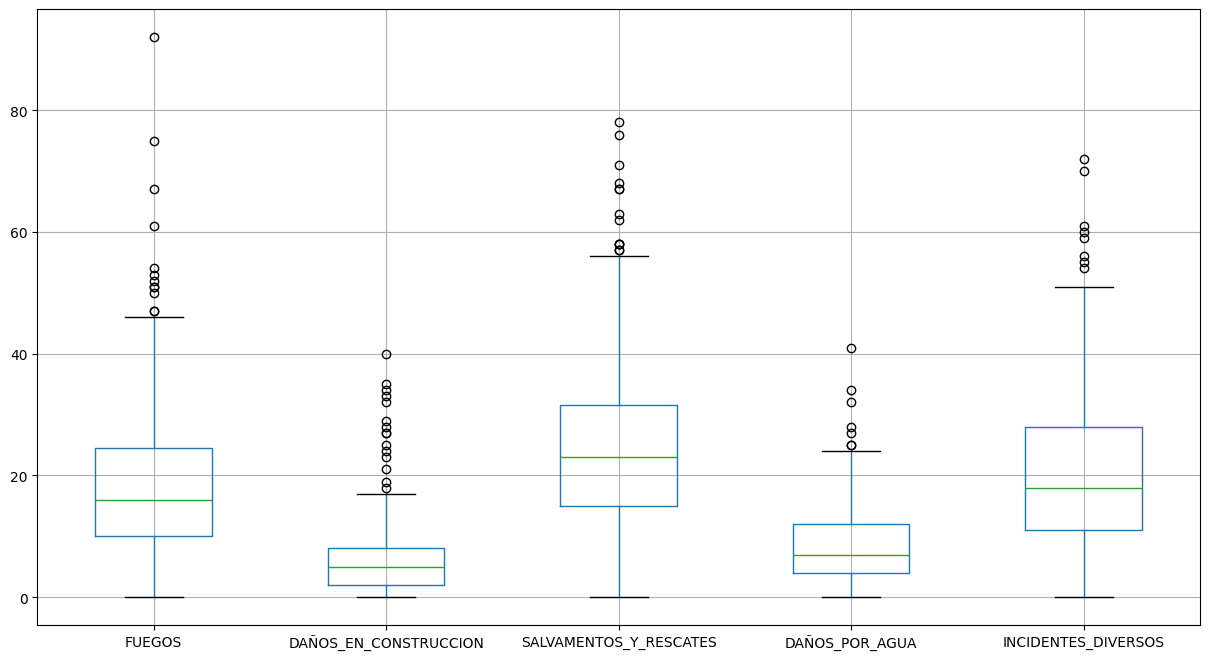

In [64]:
pd.DataFrame.boxplot(data_loader.data['datasets/actuacionesBomberos'], column=['FUEGOS', 'DAÑOS_EN_CONSTRUCCION', 'SALVAMENTOS_Y_RESCATES','DAÑOS_POR_AGUA','INCIDENTES_DIVERSOS'], figsize=[15, 8])

In [65]:
horas = ['HOR1', 'HOR2','HOR3', 'HOR4', 'HOR5', 'HOR6', 'HOR7', 'HOR8', 'HOR9', 'HOR10' , 'HOR11', 'HOR12', 'HOR13', 'HOR14', 'HOR15', 'HOR16', 'HOR17', 'HOR18', 'HOR19', 'HOR20', 'HOR21', 'HOR22', 'HOR23', 'HOR24']
#data_loader.data['datasets/estaciones'].plot.bar(x=horas, y=)

In [66]:
data_loader.get_info('datasets/accidentalidad')

NUM_EXPEDIENTE          0
FECHA                   0
HORA                    0
LOCALIZACION            0
NUMERO                  0
COD_DISTRITO            0
DISTRITO                0
TIPO_ACCIDENTE          0
ESTADO_METEOROLÓGICO    0
TIPO_VEHICULO           0
TIPO_PERSONA            0
RANGO_EDAD              0
SEXO                    0
COD_LESIVIDAD           0
LESIVIDAD               0
COORDENADA_X_UTM        0
COORDENADA_Y_UTM        0
POSITIVA_ALCOHOL        0
POSITIVA_DROGA          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 31157
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NUM_EXPEDIENTE        195610 non-null  object        
 1   FECHA                 195610 non-null  datetime64[ns]
 2   HORA                  195610 non-null  object        
 3   LOCALIZACION          195610 non-null  object        
 4   NUMERO                195610 

In [67]:
data_loader.dataframe_summary('datasets/estaciones')

,HOR1,HOR2,HOR3,HOR4,HOR5,HOR6,HOR7,HOR8,HOR9,HOR10,...,HOR15,HOR16,HOR17,HOR18,HOR19,HOR20,HOR21,HOR22,HOR23,HOR24
count,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,...,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0
mean,349.353866,249.446738,178.583074,143.306919,143.192686,228.891688,470.235663,770.226863,898.403065,897.940446,...,1006.635106,980.84632,959.616647,991.763594,1009.949269,987.990504,882.815997,734.660088,589.956675,462.854516
std,586.664755,435.311425,304.584859,223.363963,181.366051,253.470562,572.285139,1065.301401,1223.765007,1218.726208,...,1356.291987,1391.08328,1288.042121,1251.292668,1302.56987,1322.411338,1267.157291,1184.800883,973.216178,742.784157
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,74.0,46.0,34.0,30.0,38.0,56.0,98.0,171.0,232.0,274.0,...,333.0,303.0,308.0,334.0,344.0,335.0,290.0,223.0,162.0,118.0
50%,170.0,115.0,84.0,73.0,85.0,142.0,244.0,432.0,545.0,570.0,...,628.0,603.0,623.0,662.0,661.0,624.0,522.0,409.0,318.0,245.0
75%,378.0,264.0,195.0,158.0,179.0,323.0,625.0,1017.0,1089.0,1046.0,...,1224.0,1143.0,1138.0,1216.0,1245.0,1205.0,1032.0,815.0,672.0,533.0
max,9999.0,7854.0,9999.0,5805.0,3610.0,6234.0,5985.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9991.0,7557.0
counts,43070,43070,43070,43070,43070,43070,43070,43070,43070,43070,...,43070,43070,43070,43070,43070,43070,43070,43070,43070,43070
uniques,2444,2060,1594,1331,1192,1386,2647,3614,3986,3948,...,3942,3833,3630,3863,3924,3843,3789,3458,3096,2682


In [68]:
data_loader.dataframe_summary('DireccionesEvolucionHistorica_20231004.csv')

,COD_VIA,COD_NDP,NÚMERO
count,371584.0,371584.0,371584.0
mean,2408660.396707,17547202.021718,82.853409
std,7645452.207957,8153265.087079,920.868559
min,127.0,11000001.0,1.0
25%,140400.0,11052980.75,9.0
50%,391700.0,11124680.5,21.0
75%,630200.0,20166508.75,47.0
max,31006109.0,31071551.0,61000.0
counts,371584,371584,371584
uniques,9464,253372,2106


In [69]:
data_loader.dataframe_summary('DireccionesVigentes_20231004.csv')

,COD_VIA,NUMERO,COD_NDP,DISTRITO,BARRIO,COD_POSTAL,ANGULO_ROTULACION
count,210384.0,210384.0,210384.0,210384.0,210384.0,210384.0,210384.0
mean,2566230.727684,81.092307,17522404.731344,11.284119,3.750076,28029.558407,180.928657
std,7927978.567944,1051.243757,8089368.83351,5.508962,2.017848,17.168581,138.1519
min,127.0,0.0,11000001.0,1.0,1.0,28001.0,0.0
25%,119000.0,8.0,11061237.75,8.0,2.0,28019.0,44.84
50%,388100.0,19.0,11127486.5,11.0,4.0,28029.0,151.555
75%,632000.0,43.0,20164205.75,16.0,5.0,28041.0,317.82
max,31006072.0,61000.0,31071551.0,21.0,9.0,28925.0,360.0
counts,210384,210384,210384,210384,210384,210384,210384
uniques,8479,1244,210276,21,9,62,20809


In [70]:
data_loader.dataframe_summary('iluminacion.csv')

,"NUMERO,N,10,0","COD_NDP,N,10,0","DISTRITO,N,10,0","BARRIO,N,10,0"
count,231852.0,231852.0,231852.0,231852.0
mean,422.704182,19364601.663013,11.447216,3.775844
std,3796.750322,8672057.496703,5.563872,1.989844
min,0.0,11000001.0,1.0,1.0
25%,7.0,11074864.0,8.0,2.0
50%,19.0,20020646.0,11.0,4.0
75%,50.0,31016534.0,16.0,5.0
max,61000.0,31068924.0,21.0,9.0
counts,231852,231852,231852,231852
uniques,787,109999,21,9


In [71]:
data_loader.dataframe_summary('padron22.csv')

,Ï»¿EJERICIO,COD_DISTRITO,COD_BARRIO,CONTADOR
count,180345.0,180345.0,180345.0,180345.0
mean,2022.0,9.889379,99.822352,10.069434
std,0.0,5.90113,60.665245,77.008243
min,2022.0,0.0,0.0,1.0
25%,2022.0,5.0,51.0,1.0
50%,2022.0,9.0,95.0,2.0
75%,2022.0,15.0,152.0,5.0
max,2022.0,21.0,215.0,7862.0
counts,180345,180345,180345,180345
uniques,1,22,132,708


In [72]:
data_loader.dataframe_summary('RADARES_FIJOS_vDTT.csv')

,Nº\nRADAR
count,29.0
mean,15.0
std,8.514693
min,1.0
25%,8.0
50%,15.0
75%,22.0
max,29.0
counts,29
uniques,29


In [73]:
data_loader.dataframe_summary('VialesEvolucionHistorica_20231004.csv')

,COD_VIA,VIA_SQC
count,16446.0,16446.0
mean,4175345.431655,1.312842
std,10082926.753856,0.668149
min,125.0,1.0
25%,172206.25,1.0
50%,470175.0,1.0
75%,733057.5,1.0
max,99000000.0,13.0
counts,16446,16446
uniques,12554,13


In [74]:
data_loader.dataframe_summary('VialesVigentesDistritosBarrios_20231004.csv')

,COD_VIA,DISTRITO,BARRIO
count,11014.0,10990.0,10990.0
mean,4248101.971128,11.142493,3.605732
std,10196393.711887,5.739252,2.068502
min,127.0,1.0,0.0
25%,121825.0,7.0,2.0
50%,434000.0,11.0,3.0
75%,704068.75,16.0,5.0
max,31006183.0,21.0,9.0
counts,11014,10990,10990
uniques,9354,21,10


In [75]:
data_loader.dataframe_summary('VialesVigentesDistritos_20231004.csv')

,COD_VIA,DISTRITO
count,9839.0,9815.0
mean,4146937.609716,11.178502
std,10079147.61775,5.745088
min,127.0,1.0
25%,122475.0,7.0
50%,434650.0,11.0
75%,703150.0,16.0
max,31006183.0,21.0
counts,9839,9815
uniques,9354,21


In [76]:
data_loader.dataframe_summary('VialesVigentes_20231004.csv')

,COD_VIA,COD_VIA_COMIENZA,COD_VIA_TERMINA
count,9388.0,9388.0,9388.0
mean,4042814.759906,3466096.384001,8018823.443012
std,9961522.633361,11504118.496724,22587878.066217
min,127.0,127.0,127.0
25%,118493.75,139028.75,141550.0
50%,429850.0,419000.0,440375.0
75%,698962.5,667800.0,713200.0
max,31006183.0,99000003.0,99000003.0
counts,9388,9388,9388
uniques,9354,3446,3821



Tabla de frecuencia relativa de accidentes por distritos. En esta tabla se obtiene la frecuencia de accidentes en todos los distritos de madrid, esto hace que se pueda obtener también el tráfico de coches en el distrito. Aunque no sea una relación proporcional, a mayor número de accidentes supone un tráfico mayor en la zona.

C:\Users\paula\AppData\Local\Temp\ipykernel_14440\20842339.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(aux_df.index, rotation=90)


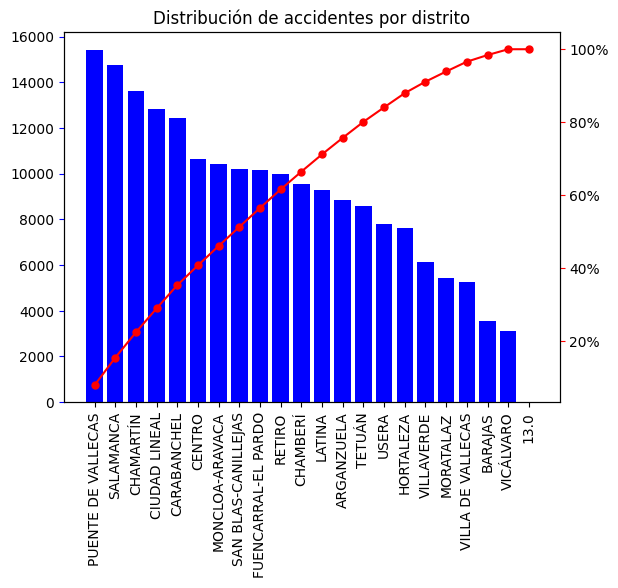

In [77]:
data_loader.data['datasets/accidentalidad']['DISTRITO'] = data_loader.data['datasets/accidentalidad']['DISTRITO'].astype(str)
CSVDataLoader.create_graph(data_loader.data['datasets/accidentalidad'], 'DISTRITO', 'accidentes por distrito')

Tabla comparativa que muestra los accidentes donde la persona que lo ha padecido ha dado positivo en alcohol.

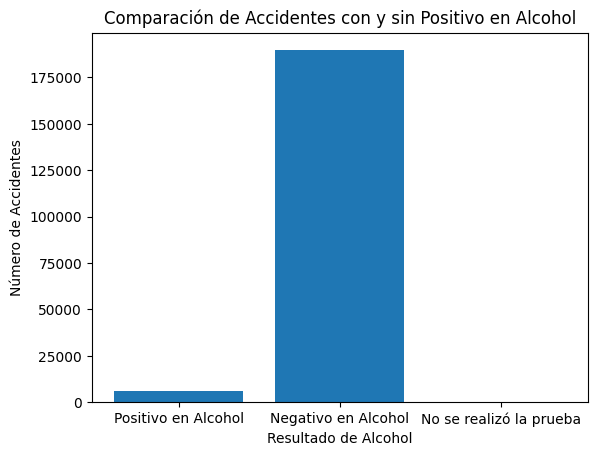

In [78]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'S']
negativos = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'N']
labels = ['Positivo en Alcohol', 'Negativo en Alcohol', 'No se realizó la prueba']
values = [len(positivos), len(negativos), len(accidentes) - len(positivos) - len(negativos)]
plt.bar(labels, values)
plt.xlabel('Resultado de Alcohol')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Alcohol')
plt.show()

Tabla comparativo donde la persona que ha padecido el accidente ha dado positivo en drogas.

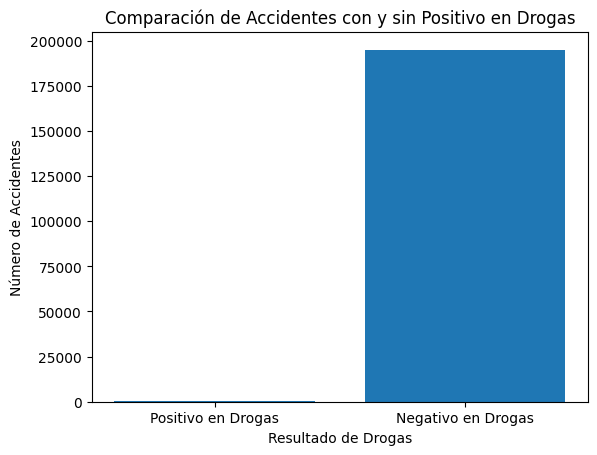

In [79]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos = accidentes[accidentes['POSITIVA_DROGA'] == 1]
negativos = accidentes[accidentes['POSITIVA_DROGA'] == 0]
labels = ['Positivo en Drogas', 'Negativo en Drogas']
values = [len(positivos), len(negativos)]
plt.bar(labels, values)
plt.xlabel('Resultado de Drogas')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Drogas')
plt.show()

Tabla comparativa que relaciona los accidente en los que la persona ha dado positivo en alcohol y drogas

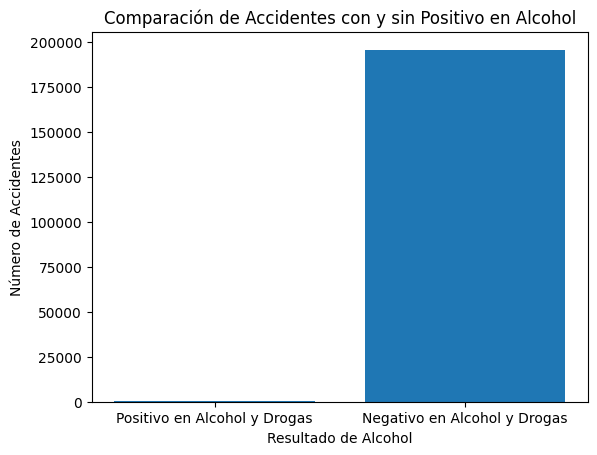

In [80]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos_alcohol = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'S']
positivos_drogas = accidentes[accidentes['POSITIVA_DROGA'] == 1]
positivos_alcohol_drogas = positivos_alcohol[positivos_alcohol['POSITIVA_DROGA'] == 1]
positivos_alcohol_drogas = len(positivos_alcohol_drogas)
negativos = len(accidentes) - positivos_alcohol_drogas
labels = ['Positivo en Alcohol y Drogas', 'Negativo en Alcohol y Drogas']
values = [positivos_alcohol_drogas, negativos]
plt.bar(labels, values)
plt.xlabel('Resultado de Alcohol')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Alcohol')
plt.show()

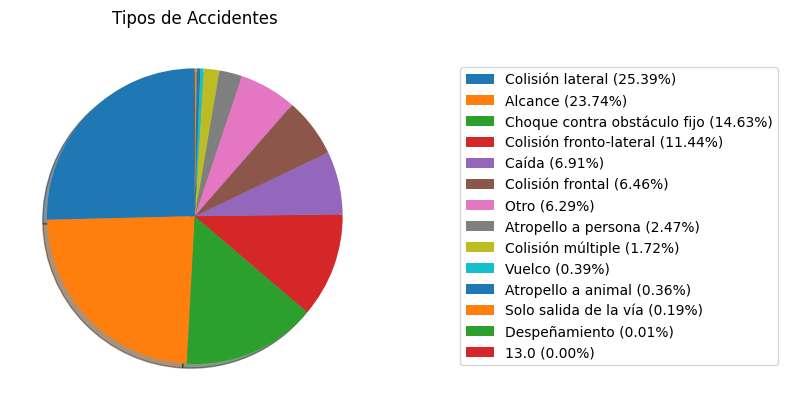

In [81]:
accidentes = data_loader.data['datasets/accidentalidad']
labels = accidentes['TIPO_ACCIDENTE'].unique()
values = accidentes['TIPO_ACCIDENTE'].value_counts()
percentages = (values / len(accidentes)) * 100
plt.pie(values, shadow=True, startangle=90)
plt.title('Tipos de Accidentes')
legend_labels = [f'{label} ({percentage:.2f}%)' for label, percentage in zip(labels, percentages)]
plt.legend(labels=legend_labels, loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

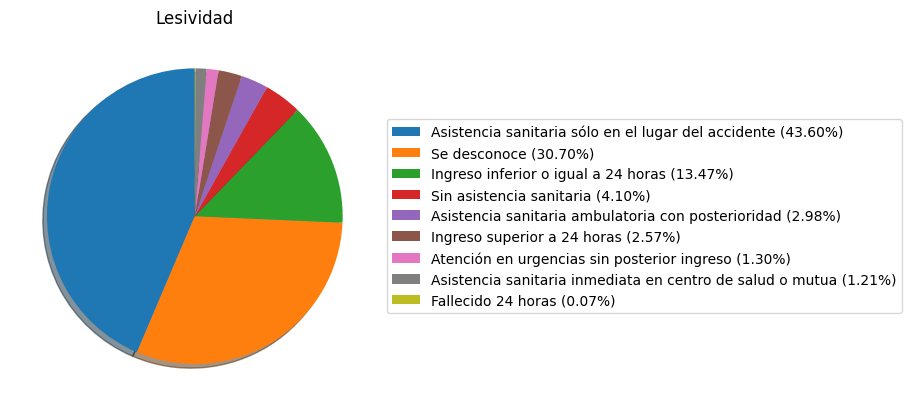

In [82]:
accidentes = data_loader.data['datasets/accidentalidad']
labels = accidentes['LESIVIDAD'].unique()
values = accidentes['LESIVIDAD'].value_counts()
percentages = (values / len(accidentes)) * 100
plt.pie(values, shadow=True, startangle=90)
plt.title('Lesividad')
legend_labels = [f'{label} ({percentage:.2f}%)' for label, percentage in zip(labels, percentages)]
plt.legend(labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

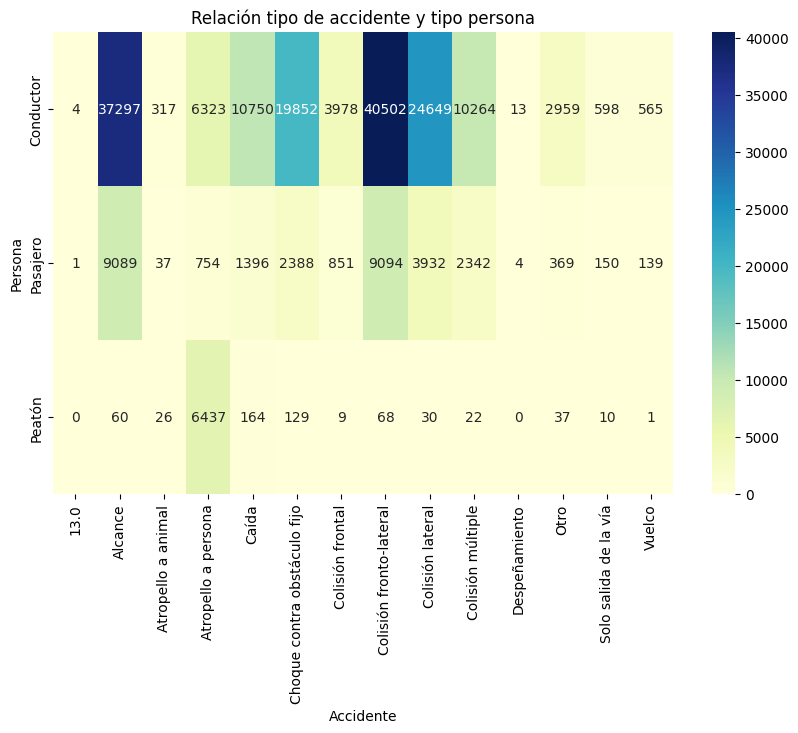

In [83]:
# Create a cross-tabulation of TIPO_PERSONA and TIPO_ACCIDENTE
cross_tab = pd.crosstab(accidentes['TIPO_PERSONA'], accidentes['TIPO_ACCIDENTE'])

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Relación tipo de accidente y tipo persona')
plt.xlabel('Accidente')
plt.ylabel('Persona')

plt.show()

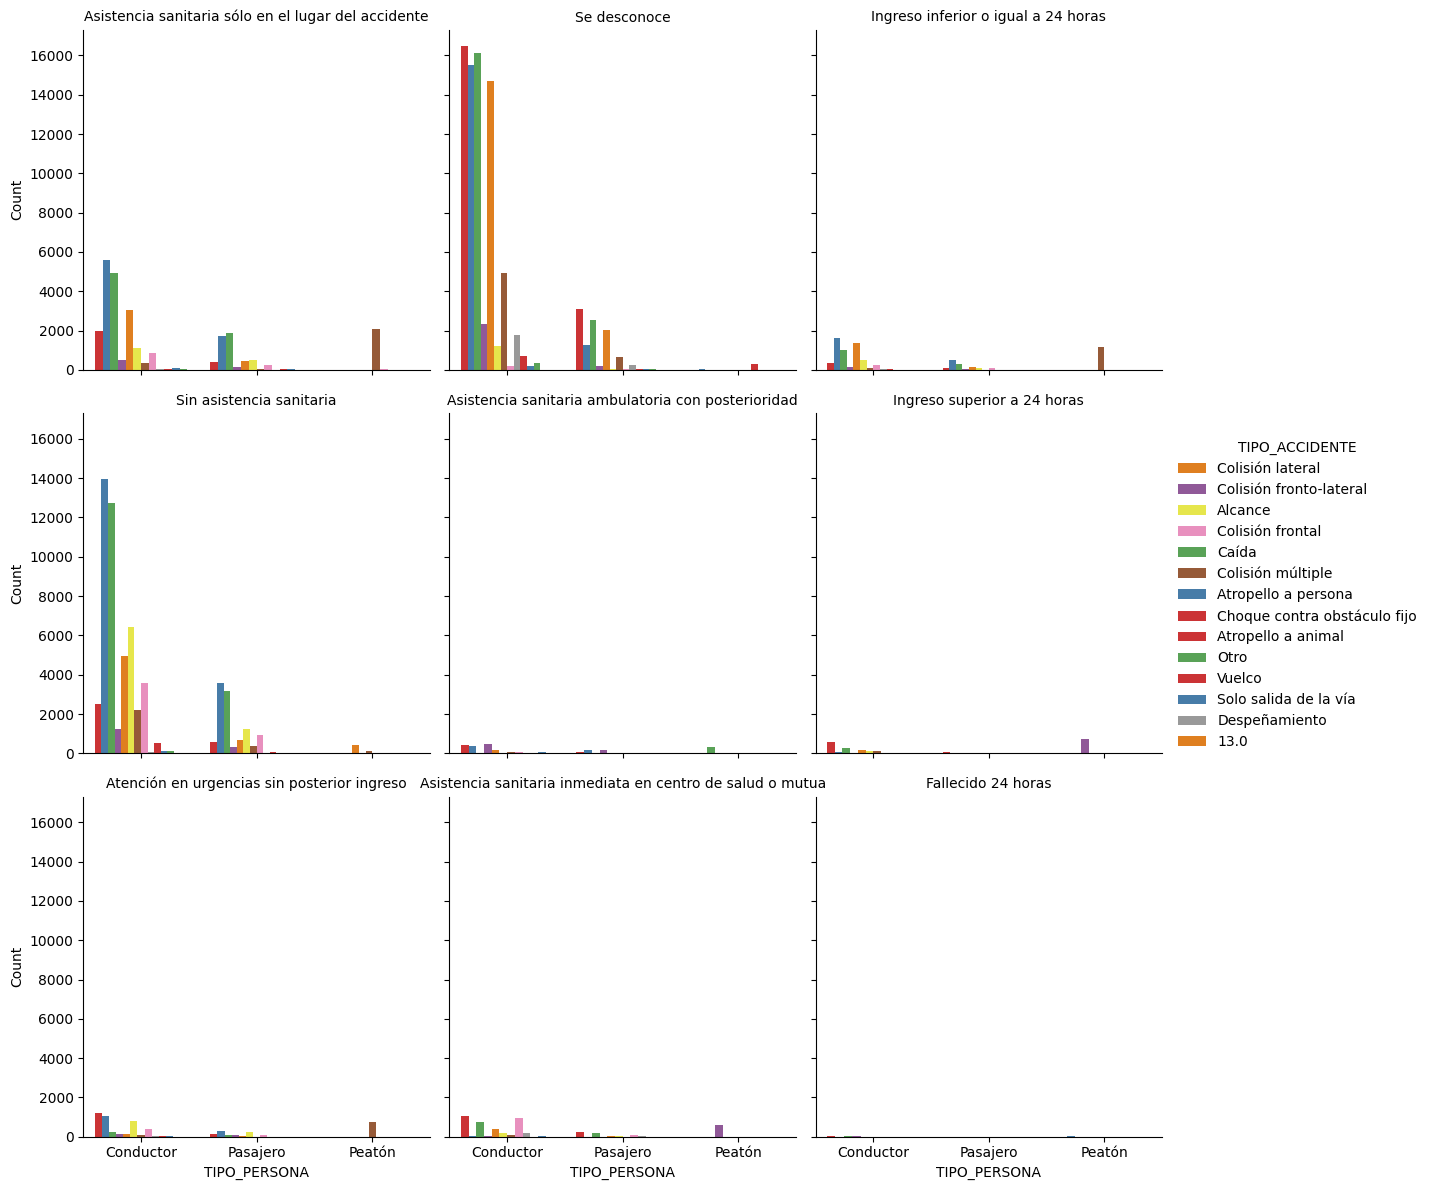

In [84]:
# Create a faceted plot
g = sns.FacetGrid(accidentes, col='LESIVIDAD', height=4, col_wrap=3)
g.map_dataframe(sns.countplot, x='TIPO_PERSONA', hue='TIPO_ACCIDENTE', palette='Set1')
g.set_axis_labels('TIPO_PERSONA', 'Count')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend(title='TIPO_ACCIDENTE')

plt.show()

C:\Users\paula\AppData\Local\Temp\ipykernel_14440\2814729789.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(wrapped_labels)


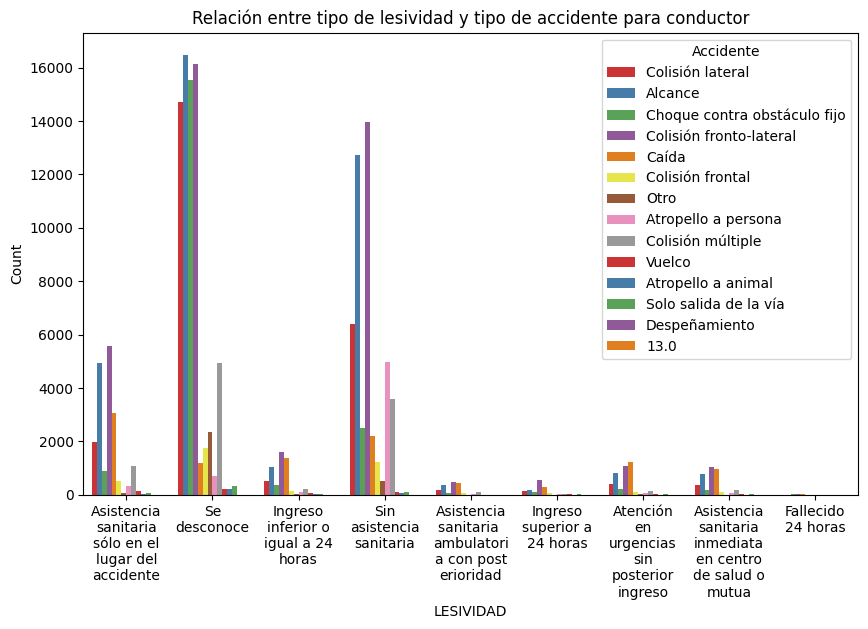

In [85]:
# Filter the DataFrame for cases where TIPO_PERSONA is 'Driver'
df_driver = accidentes[accidentes['TIPO_PERSONA'] == 'Conductor']

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=df_driver, x='LESIVIDAD', hue='TIPO_ACCIDENTE', palette='Set1')

# Wrap the x-axis labels
wrapped_labels = [textwrap.fill(label.get_text(), 10) for label in plot.get_xticklabels()]
plot.set_xticklabels(wrapped_labels)

plt.title('Relación entre tipo de lesividad y tipo de accidente para conductor')
plt.xlabel('LESIVIDAD')
plt.ylabel('Count')
plt.legend(title='Accidente')

plt.show()

C:\Users\paula\AppData\Local\Temp\ipykernel_14440\480348612.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(wrapped_labels)


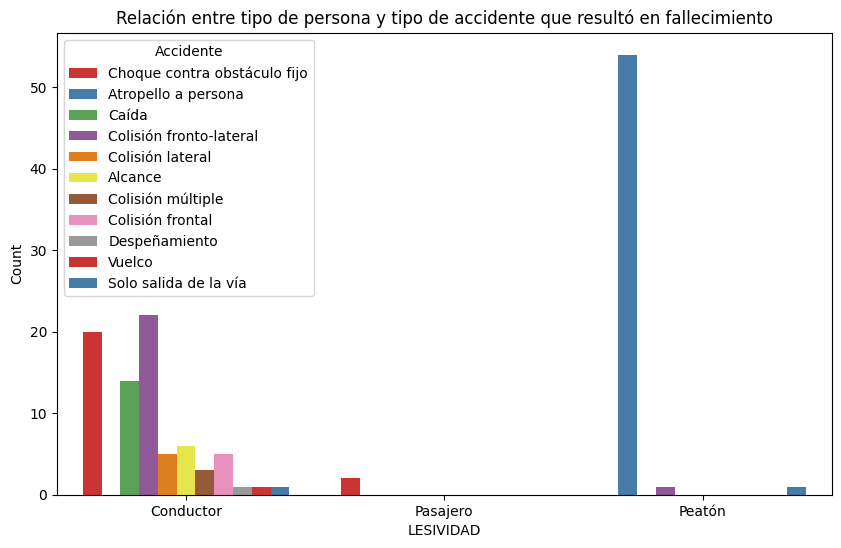

In [86]:
df_dead = accidentes[accidentes['COD_LESIVIDAD'] == 4]

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=df_dead, x='TIPO_PERSONA', hue='TIPO_ACCIDENTE', palette='Set1')

# Wrap the x-axis labels
wrapped_labels = [textwrap.fill(label.get_text(), 10) for label in plot.get_xticklabels()]
plot.set_xticklabels(wrapped_labels)

plt.title('Relación entre tipo de persona y tipo de accidente que resultó en fallecimiento')
plt.xlabel('LESIVIDAD')
plt.ylabel('Count')
plt.legend(title='Accidente')

plt.show()

C:\Users\paula\AppData\Local\Temp\ipykernel_14440\1956786289.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_peaton, x='ESTADO_METEOROLÓGICO', palette='dark')


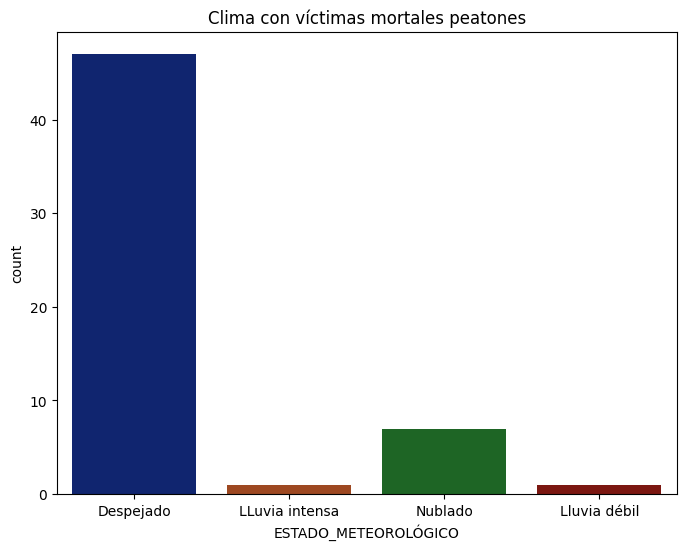

In [87]:
df_peaton = accidentes[(accidentes['TIPO_PERSONA'] == 'Peatón') & (accidentes['COD_LESIVIDAD'] == 4)]

# Plot the count of ESTADO_METEOROLOGICO
plt.figure(figsize=(8, 6))
sns.countplot(data=df_peaton, x='ESTADO_METEOROLÓGICO', palette='dark')
plt.title('Clima con víctimas mortales peatones')
plt.show()

In [88]:
estaciones = data_loader.data['datasets/estaciones']


In [89]:
direccionesvigentes = data_loader.data['DireccionesVigentes_20231004.csv']

In [90]:
data_loader.get_info('padron22.csv')

Ï»¿EJERICIO                 0
COD_TIPO_PERSONA            0
TIPO_PERSONA                0
COD_DISTRITO                0
DISTRITO                    0
COD_BARRIO                  0
BARRIO                      0
COD_TIPO_VEHÃCULO          0
TIPO_VEHÃCULO              0
ETIQUETA_MEDIOAMBIENTAL     0
CLASIFICACIÃN_AMBIENTAL    0
CUOTA                       0
TIPO_CARBURANTE             0
AÃO_MATRICULACIÃN         0
CONTADOR                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180345 entries, 0 to 180344
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Ï»¿EJERICIO               180345 non-null  int64 
 1   COD_TIPO_PERSONA          180345 non-null  object
 2   TIPO_PERSONA              180345 non-null  object
 3   COD_DISTRITO              180345 non-null  int64 
 4   DISTRITO                  180345 non-null  object
 5   COD_BARRIO                180345 non

In [91]:
data_loader.data['padron22.csv'] = data_loader.data['padron22.csv'].rename(columns={'TIPO_VEHÃCULO': 'TIPO_VEHICULO'})
data_loader.data['padron22.csv'] = data_loader.data['padron22.csv'].rename(columns={'COD_TIPO_VEHÃCULO': 'COD_TIPO_VEHICULO'})

padron = data_loader.data['padron22.csv']
print(data_loader.data['padron22.csv']['COD_TIPO_VEHICULO'].unique())



['CA' 'MT' 'RE' 'TR' 'TU' 'CI' 'AU' 'SE']


In [92]:
'''census_proportions = padron['TIPO_VEHICULO'].value_counts(normalize=True)

accidentalidad_proportions = accidentes['TIPO_VEHICULO'].value_counts(normalize=True)

value_mapping_dict = {
    'Autobús': 'AUTOBUS',
    'Autobus EMT': 'AUTOBUS',
    'Autobús articulado': 'AUTOBUS',
    'Autobús articulado EMT': 'AUTOBUS',
    'Camión de bomberos': 'CAMION',
    'Camión rígido': 'CAMION',
    'Ciclomotor': 'CICLOMOTOR',
    'Ciclomotor de tres ruedas': 'CICLOMOTOR',
    'Ciclomotor de dos ruedas L1e-B': 'CICLOMOTOR',
    'Moto de tres ruedas > 125cc': 'MOTOCICLETA',
    'Moto de tres ruedas hasta 125cc': 'MOTOCICLETA',
    'Motocicleta > 125cc': 'MOTOCICLETA',
    'Motocicleta hasta 125cc': 'MOTOCICLETA',
    'Remolque': 'REMOLQUE',
    'Semirremolque': 'SEMIRREMOLQUE',
    'Tractocamión': 'TRACTOR',
    'Turismo': 'TURISMO',
}

columnasAcc = ['TIPO_VEHICULO', 'COD_LESIVIDAD', 'TIPO_ACCIDENTE']
accidenteSubset = accidentes[columnasAcc]
padronSubset = padron['TIPO_VEHICULO']

accidenteSubset.loc[:, 'TIPO_VEHICULO'] = accidenteSubset['TIPO_VEHICULO'].replace(value_mapping_dict)

# Merge the datasets on the common column(s)
merged_data = pd.merge(accidenteSubset, padronSubset, on='TIPO_VEHICULO', how='inner')

# Create a DataFrame with proportions for the merged data
proportions_df = pd.DataFrame({
    'Accidentalidad': merged_data['TIPO_VEHICULO'].value_counts(normalize=True),
    'Census': merged_data['Proportion_Column'].value_counts(normalize=True)
})

proportions_df = pd.DataFrame({
    'Census': census_proportions,
    'Accidentalidad': accidentalidad_proportions
})

# Step 4: Compare Distributions using Heatmap
plt.figure(figsize=(12, 6))

sns.heatmap(proportions_df.T, annot=False, cmap="", cbar=True)
plt.title('Proportions of Vehicle Types in Census and Accidentalidad Datasets')


plt.show()'''

'census_proportions = padron[\'TIPO_VEHICULO\'].value_counts(normalize=True)\n\naccidentalidad_proportions = accidentes[\'TIPO_VEHICULO\'].value_counts(normalize=True)\n\nvalue_mapping_dict = {\n    \'Autobús\': \'AUTOBUS\',\n    \'Autobus EMT\': \'AUTOBUS\',\n    \'Autobús articulado\': \'AUTOBUS\',\n    \'Autobús articulado EMT\': \'AUTOBUS\',\n    \'Camión de bomberos\': \'CAMION\',\n    \'Camión rígido\': \'CAMION\',\n    \'Ciclomotor\': \'CICLOMOTOR\',\n    \'Ciclomotor de tres ruedas\': \'CICLOMOTOR\',\n    \'Ciclomotor de dos ruedas L1e-B\': \'CICLOMOTOR\',\n    \'Moto de tres ruedas > 125cc\': \'MOTOCICLETA\',\n    \'Moto de tres ruedas hasta 125cc\': \'MOTOCICLETA\',\n    \'Motocicleta > 125cc\': \'MOTOCICLETA\',\n    \'Motocicleta hasta 125cc\': \'MOTOCICLETA\',\n    \'Remolque\': \'REMOLQUE\',\n    \'Semirremolque\': \'SEMIRREMOLQUE\',\n    \'Tractocamión\': \'TRACTOR\',\n    \'Turismo\': \'TURISMO\',\n}\n\ncolumnasAcc = [\'TIPO_VEHICULO\', \'COD_LESIVIDAD\', \'TIPO_ACCIDENT

In [97]:
data_loader.data ["datasets/accidentalidad"].head()

,NUM_EXPEDIENTE,FECHA,HORA,LOCALIZACION,NUMERO,COD_DISTRITO,DISTRITO,TIPO_ACCIDENTE,ESTADO_METEOROLÓGICO,TIPO_VEHICULO,TIPO_PERSONA,RANGO_EDAD,SEXO,COD_LESIVIDAD,LESIVIDAD,COORDENADA_X_UTM,COORDENADA_Y_UTM,POSITIVA_ALCOHOL,POSITIVA_DROGA
0,2018S017842,2019-02-04,9:10:00,"CALL. ALBERTO AGUILERA, 1",1,1.0,CENTRO,Colisión lateral,Despejado,Motocicleta > 125cc,Conductor,De 45 a 49 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,"440068,049","4475679,17",N,0.0
1,2018S017842,2019-02-04,9:10:00,"CALL. ALBERTO AGUILERA, 1",1,1.0,CENTRO,Colisión lateral,Despejado,Turismo,Conductor,De 30 a 34 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,"440068,049","4475679,17",N,0.0
2,2019S000001,2019-01-01,3:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,Se desconoce,Furgoneta,Conductor,De 40 a 44 años,Hombre,77.0,Se desconoce,"439139,603","4470836,854",S,0.0
3,2019S000001,2019-01-01,3:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,Se desconoce,Turismo,Conductor,De 40 a 44 años,Mujer,77.0,Se desconoce,"439139,603","4470836,854",N,0.0
4,2019S000001,2019-01-01,3:45:00,PASEO. SANTA MARIA DE LA CABEZA / PLAZA. ELIPTICA,168,11.0,CARABANCHEL,Alcance,Se desconoce,Turismo,Conductor,De 45 a 49 años,Mujer,77.0,Se desconoce,"439139,603","4470836,854",N,0.0


In [ ]:
df.plot(x="longitude", y="latitude", kind="scatter", c="brightness",
        colormap="YlOrRd")